In [1]:
import sys

import torch.utils
import torch.utils.data
sys.path.append('.')
import torch
import torch.nn as nn
import random
import os
import os.path as osp
import pickle as pkl
import numpy as np
import argparse
from models import build_model, Group_helper
from dsets import get_loaders
from losses import LossFunction
from tqdm import tqdm
import torch.nn.functional as F
from utils import get_optimizer_clip, get_optimizer_mlp, obtain_language_references
from custom_parser import Parser
from utils import network_forward_clip
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-21 14:50:57.366888: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-21 14:50:58.198306: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.8/lib64
2025-04-21 14:50:58.198421: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.

In [2]:
os.environ['http_proxy'] = "10.10.78.21:3128"
os.environ['https_proxy'] = "10.10.78.21:3128"
os.environ['TORCH_DISTRIBUTED_DEBUG'] = 'INFO'
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [3]:
gpu = 0
device = torch.device(f'cuda:{gpu}')

In [4]:
random_seed = 12
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
def load_checkpoints(args, feature_extractor, language_prototypes, optimizer):

    backbone_type = f'{args.backbone}'
    regressor_type = f'regressor_{args.regressor}'
    clip_type = f'MM_cont_{args.multimodal_contrastive}'
    ckpt_path = f'results/{args.dataset}/{args.fold}/{backbone_type}/{clip_type}/ckpt_{regressor_type}.pth'
    ckpt = torch.load(ckpt_path, map_location='cpu')

    feature_extractor.projection_head.load_state_dict(ckpt['projection_head'])
    optimizer.load_state_dict(ckpt['optimizer'])
    if language_prototypes is not None:
        language_prototypes.learnable_tokens.load_state_dict(ckpt['peft_tokens'])
    # criterion.load_state_dict(ckpt['criterion'])

    return feature_extractor, language_prototypes, optimizer


In [6]:
def get_models(args):
    # prepare models
    feature_extractor, regressor, language_prototypes, text_processor = build_model(args, device)

    # prepare optimizer
    if args.regressor == 'clip':
        optimizer = get_optimizer_clip(args, args.lr, feature_extractor, language_prototypes)
    else:
        optimizer = get_optimizer_mlp(args, args.lr, feature_extractor, regressor)

    # Build criterion
    criterion = LossFunction(args)
    feature_extractor, language_prototypes, optimizer = load_checkpoints(args, feature_extractor, language_prototypes, optimizer)

    return feature_extractor, language_prototypes, optimizer, criterion, text_processor

In [7]:
def get_dataloaders(args):
    batch_size_train = 1
    batch_size_test = 1
    train_dataset, ref_dataset, test_dataset = get_loaders(args)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size_train // 1
        , num_workers=16, pin_memory=True
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size_test, 
        num_workers=16, pin_memory=True
    )
    return train_loader, test_loader

In [8]:
def get_args(dataset, fold, regressor='clip', depth=5, num_ranks=10, mm_cont=True):
    parser = argparse.ArgumentParser()

    args = parser.parse_args(args=[])
    args.dataset = dataset
    args.data_root = '/home/mrunmay/scratch/ActionQualityAssessment/datasets'
    args.backbone = 'VideoMAE-base-finetuned-kinetics'
    args.seed = 12
    args.epochs = 30
    args.num_clips = 10
    args.lr = 0.001
    args.feature_dim = 768
    args.projection_dim = 512
    args.temperature = 1
    args.resume = True
    args.fold = fold
    args.regressor = regressor
    args.batch_size_train = 16
    args.batch_size_test = 16
    args.binning_strategy = 'uniform'
    args.num_peft_tokens = 16
    args.use_feature_aggregation = False

    args.num_ranks = num_ranks
    args.tau = 0
    args.gamma = 0.25
    args.smin = 0
    args.smax = 10

    args.k = 2
    args.depth = depth

    args.local_rank = -1
    args.multimodal_contrastive = mm_cont
    return args


In [9]:
# one example for uniform only
@torch.no_grad()
def obtain_feats(feats, weights, feature_extractor,):
    feats = feats.to(device).float()
    weights = weights.to(device).float()
    
    # Obtain refined features
    feats_agg = feature_extractor(feats=feats, weights=weights)
    return feats_agg


def get_feats_order_score(dataset='Needle_Passing', regressor='clip', fold=0, depth=5, num_ranks=10, mm_cont=True):
    # Setup
    args = get_args(dataset=dataset, regressor=regressor, fold=fold, depth=depth, num_ranks=num_ranks, mm_cont=mm_cont)

    # Models
    feature_extractor, language_prototypes, optimizer, criterion, text_processor = get_models(args)

    # Data loaders
    train_loader, test_loader = get_dataloaders(args)

    # Training examples
    train_feats_list = {}
    train_score_list = {}

    with torch.no_grad():
        for i, (feats, weights, targets, names) in enumerate(tqdm(train_loader)):
            feats = obtain_feats(feats, weights, feature_extractor)
            train_feats_list[names[0]] = feats
            train_score_list[names[0]] = targets

    train_feats_list = list(train_feats_list.values())
    train_score_list = list(train_score_list.values())

    test_feats_list = {}
    test_score_list = {}

    with torch.no_grad():
        for i, (feats, weights, targets, names) in enumerate(tqdm(test_loader)):
            feats = obtain_feats(feats, weights, feature_extractor)
            test_feats_list[names[0]] = feats
            test_score_list[names[0]] = targets
    
    test_feats_list = list(test_feats_list.values())
    test_score_list = list(test_score_list.values())
    
    train_feats_list = torch.concat(train_feats_list)
    train_score_list = torch.concat(train_score_list, dim=0)

    test_feats_list = torch.concat(test_feats_list)
    test_score_list = torch.concat(test_score_list, dim=0)

    if language_prototypes is not None:
        text_feats, text_scores = obtain_language_references(args, text_processor, language_prototypes, feats,  16)
    else:
        text_feats, text_scores = None, None
    
    return train_feats_list, train_score_list, test_feats_list, test_score_list, text_feats, text_scores
    


In [12]:
def visualize_embeddings_normal(embeddings: torch.Tensor, labels: torch.Tensor, perplexity: int = 30, random_state: int = 42):
    
    # Convert tensors to NumPy arrays
    embeddings_np = embeddings.detach().cpu().numpy()
    labels_np = labels.detach().cpu().numpy().flatten()
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state, n_iter=1000)
    reduced_embeddings = tsne.fit_transform(embeddings_np)
    
    # Create scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels_np, cmap='jet', alpha=0.7)
    plt.colorbar(scatter, label='Labels')
    plt.title('t-SNE Visualization of Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()


def visualize_embeddings(embeddings: torch.Tensor, labels: torch.Tensor, perplexity: int = 30, split_index=10, random_state: int = 42, use_text=False):
    
    # Convert tensors to NumPy arrays
    embeddings_np = embeddings.detach().cpu().numpy()
    labels_np = labels.detach().cpu().numpy().flatten()
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state, n_iter=1000)
    reduced_embeddings = tsne.fit_transform(embeddings_np)
    
    # Separate text and visual embeddings
    text_embeddings = reduced_embeddings[:split_index]
    visual_embeddings = reduced_embeddings[split_index:]
    text_labels = labels_np[:split_index]
    visual_labels = labels_np[split_index:]
    
    # Plot text embeddings with the same color code but with brighter markers
    plt.figure(figsize=(10, 8))
    scatter_text = plt.scatter(text_embeddings[:, 0], text_embeddings[:, 1], c=text_labels, cmap='jet', edgecolors='black', s=100, label='Test Embeddings', alpha=0.9)
    
    # Plot visual embeddings with regular colors
    scatter_visual = plt.scatter(visual_embeddings[:, 0], visual_embeddings[:, 1], c=visual_labels, cmap='jet', alpha=0.7, label='Train Embeddings')
    
    plt.colorbar(scatter_visual, label='Labels')
    plt.title('t-SNE Visualization of Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.show()


def visualize_embeddings_separately(embeddings: torch.Tensor, labels: torch.Tensor, perplexity: int = 30, split_index=10, random_state: int = 42, use_text=False):
    
    # Convert tensors to NumPy arrays
    embeddings_np = embeddings.detach().cpu().numpy()
    labels_np = labels.detach().cpu().numpy().flatten()
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state, n_iter=1000)
    reduced_embeddings = tsne.fit_transform(embeddings_np)
    
    # Separate text and visual embeddings
    text_embeddings = reduced_embeddings[:split_index]
    visual_embeddings = reduced_embeddings[split_index:]
    text_labels = labels_np[:split_index]
    visual_labels = labels_np[split_index:]
    
    # Plot text embeddings with the same color code but with brighter markers
    plt.figure(figsize=(10, 8))
    scatter_text = plt.scatter(text_embeddings[:, 0], text_embeddings[:, 1], c=text_labels, cmap='jet', edgecolors='black', s=100, label='Test Embeddings', alpha=0.9)

    plt.colorbar(scatter_text, label='Labels')
    plt.title('t-SNE Visualization of Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.show()
    
    # Plot visual embeddings with regular colors
    plt.figure(figsize=(10, 8))
    scatter_visual = plt.scatter(visual_embeddings[:, 0], visual_embeddings[:, 1], c=visual_labels, cmap='jet', alpha=0.7, label='Train Embeddings')
    
    plt.colorbar(scatter_visual, label='Labels')
    plt.title('t-SNE Visualization of Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.show()

100%|██████████| 43/43 [00:01<00:00, 21.59it/s]
/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


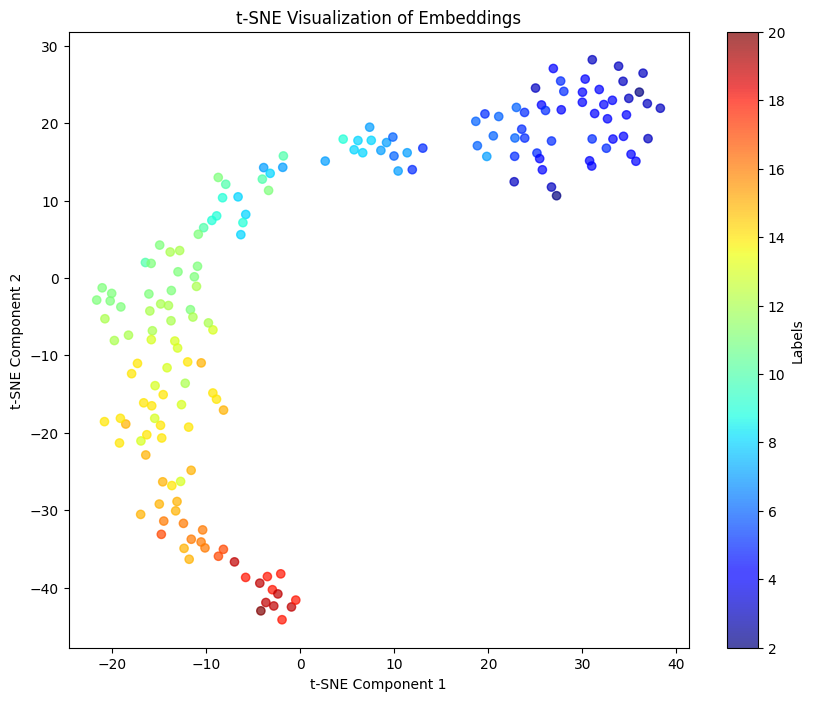

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


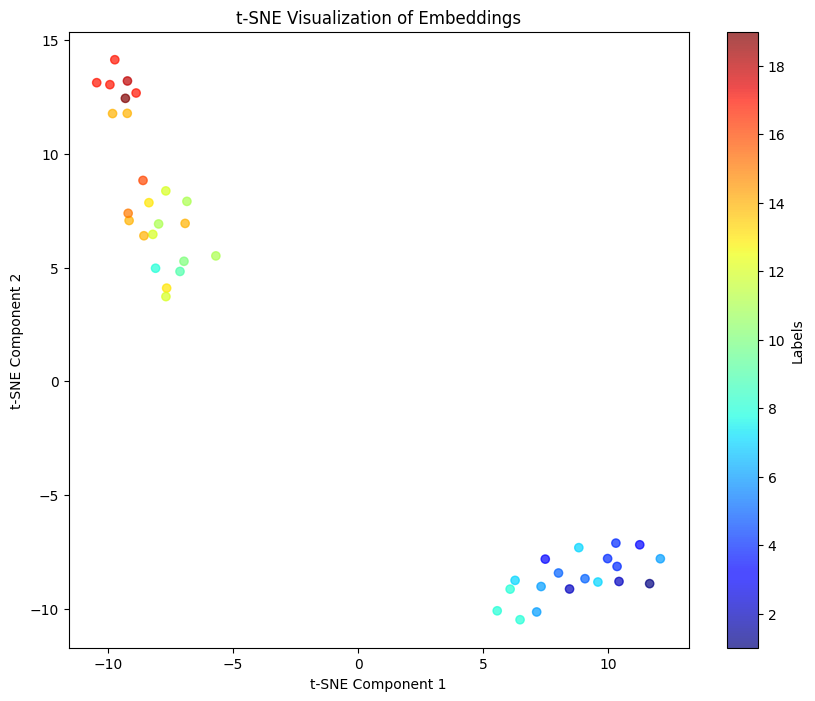

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


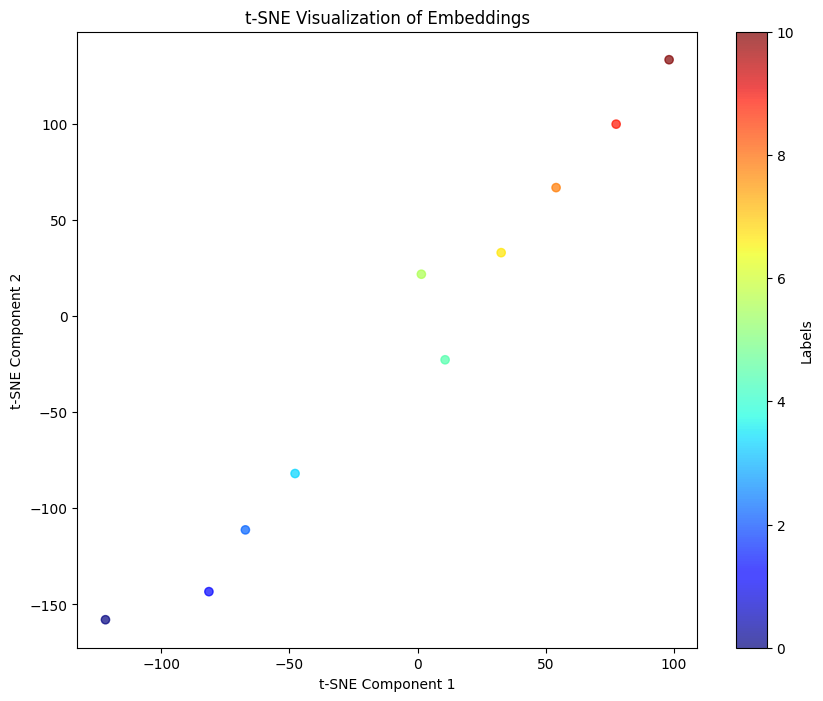

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


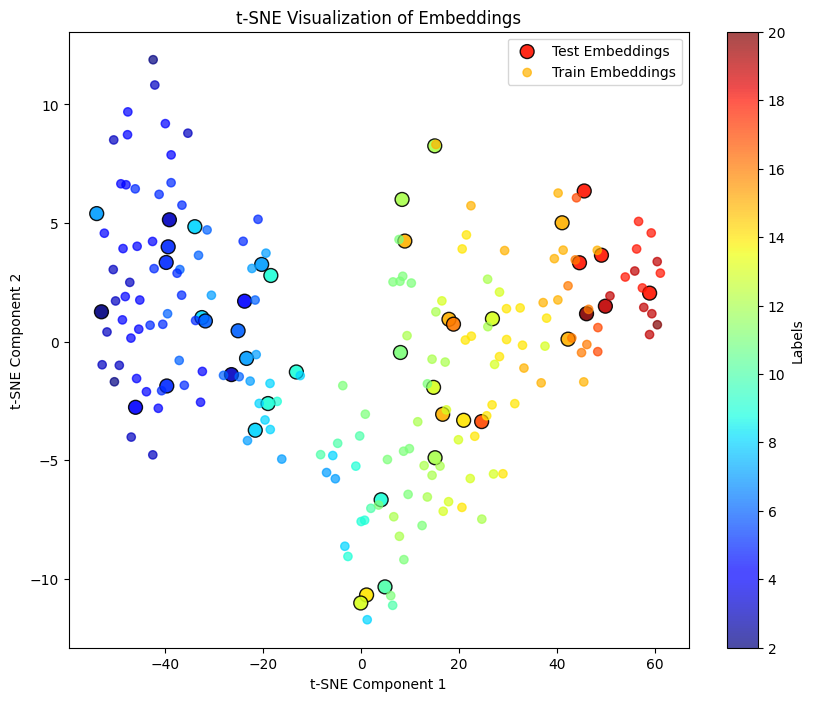

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


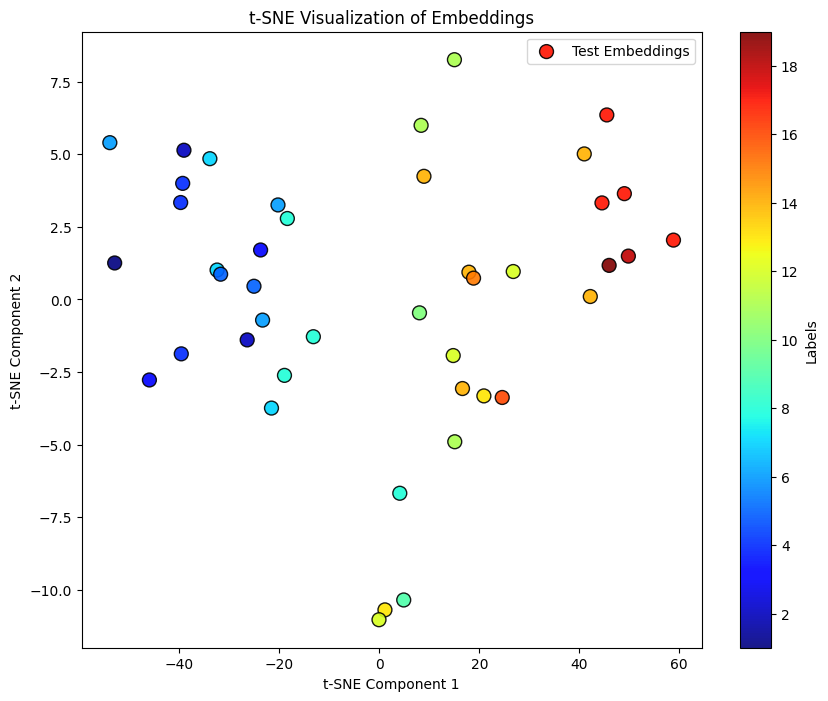

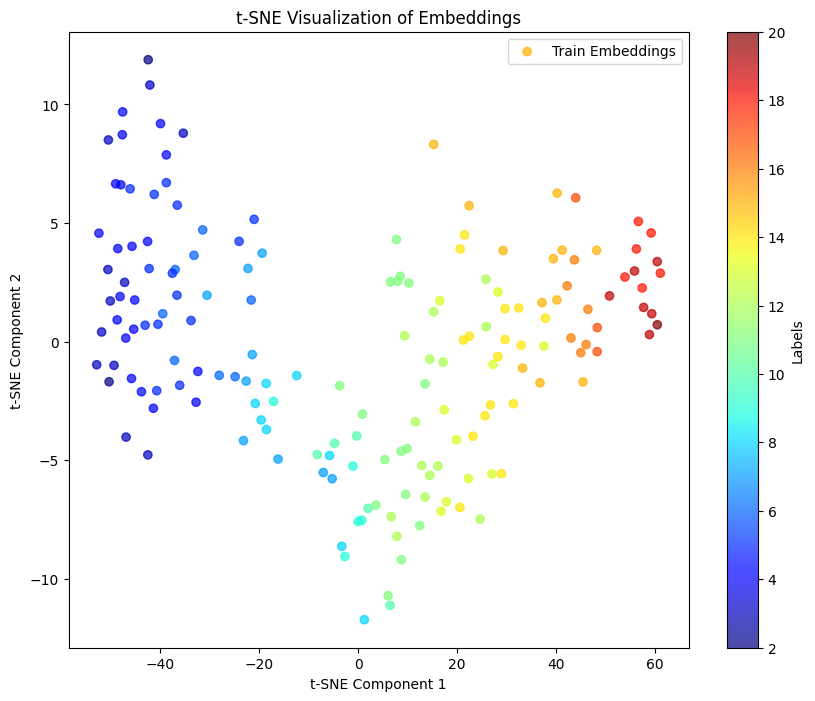

In [13]:
## NETS exp3 (clip with multimodal_cont)
train_feats_list, train_score_list, test_feats_list, test_score_list, text_feats, text_scores = get_feats_order_score('NETS', depth=4, regressor='clip')
train_feats_list = F.normalize(train_feats_list, p=2, dim=-1)
test_feats_list = F.normalize(test_feats_list, p=2, dim=-1)
visualize_embeddings_normal(train_feats_list, train_score_list, perplexity=10)
visualize_embeddings_normal(test_feats_list, test_score_list, perplexity=10)
if text_feats is not None:
    visualize_embeddings_normal(text_feats[0], text_scores[0], perplexity=3)

# Combine text and image
combined_feats = torch.concat([test_feats_list.detach().cpu(), train_feats_list.detach().cpu()], dim=0)
combined_scores = torch.concat([test_score_list.detach().cpu(), train_score_list.detach().cpu()], dim=0)
visualize_embeddings(combined_feats, combined_scores, perplexity=10, split_index=len(test_feats_list))
visualize_embeddings_separately(combined_feats, combined_scores, 10, len(test_feats_list))

100%|██████████| 64/64 [00:02<00:00, 30.59it/s]
/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


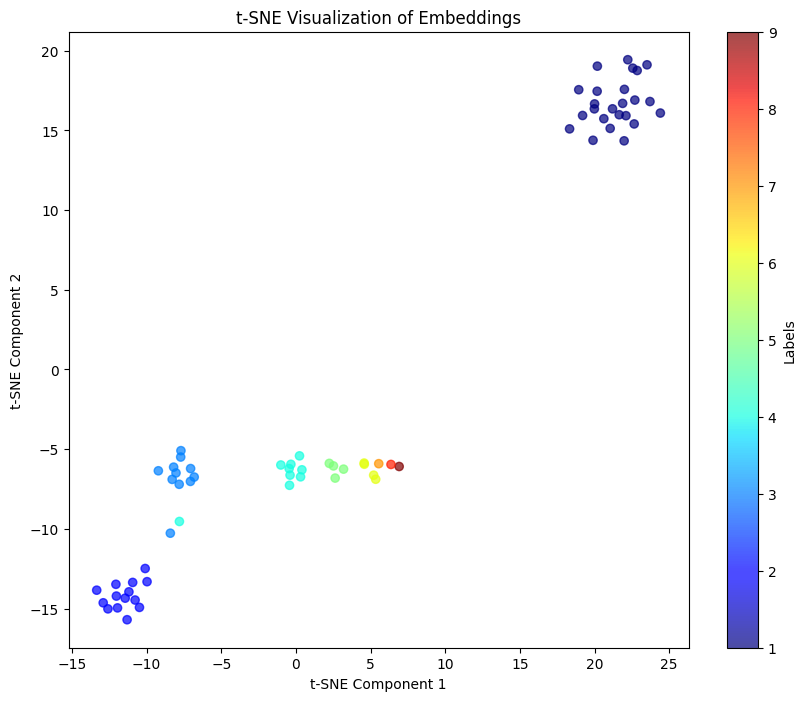

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


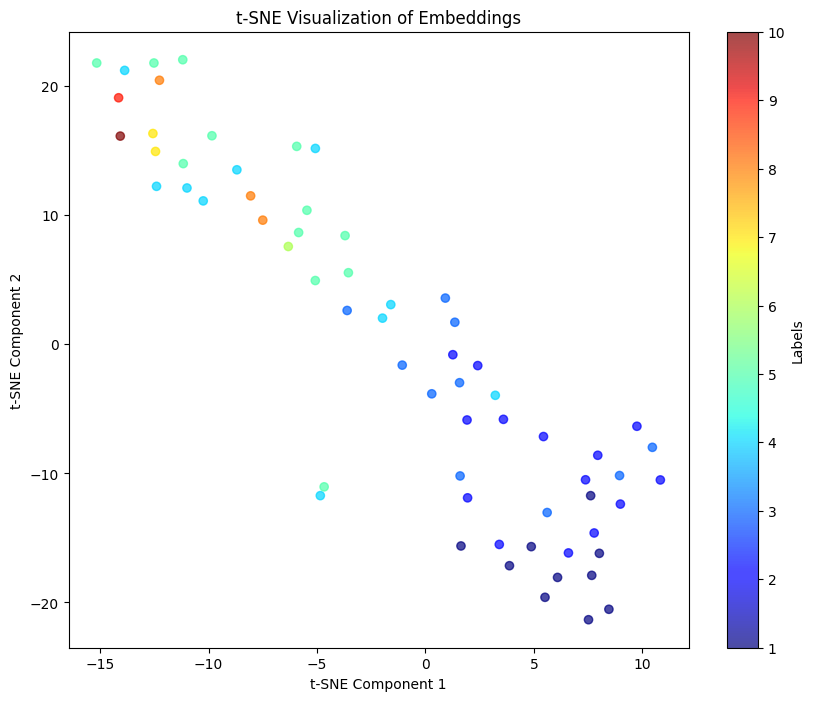

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


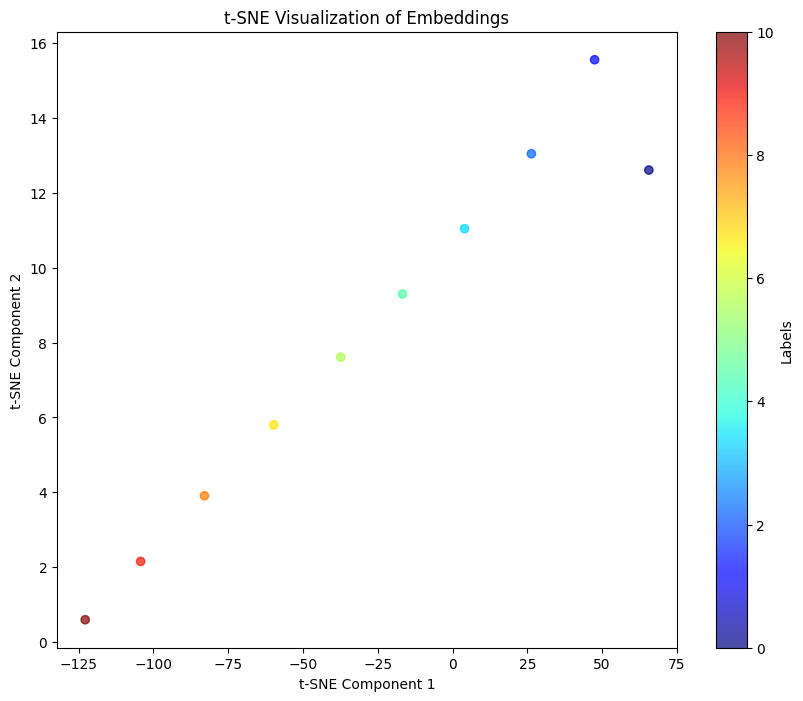

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


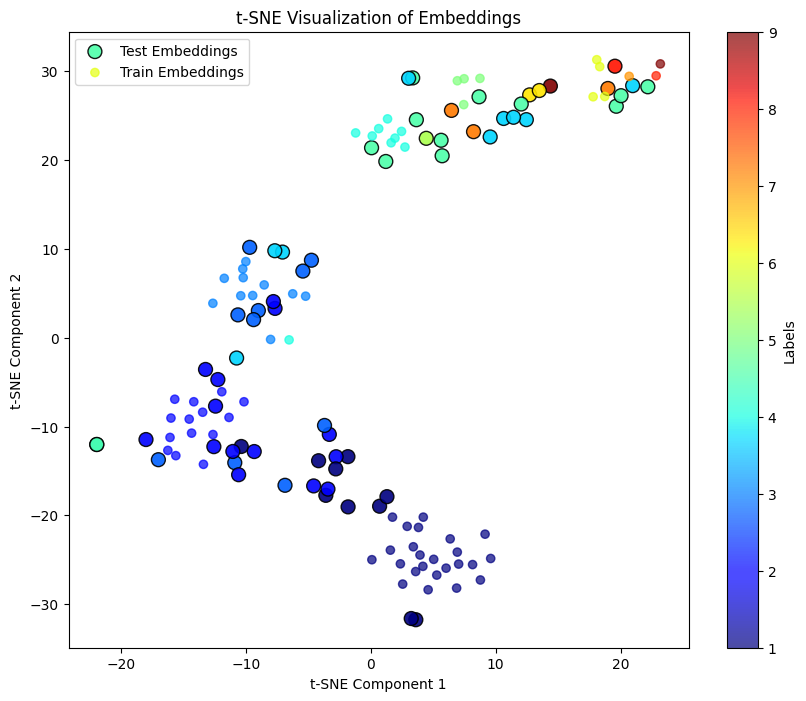

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


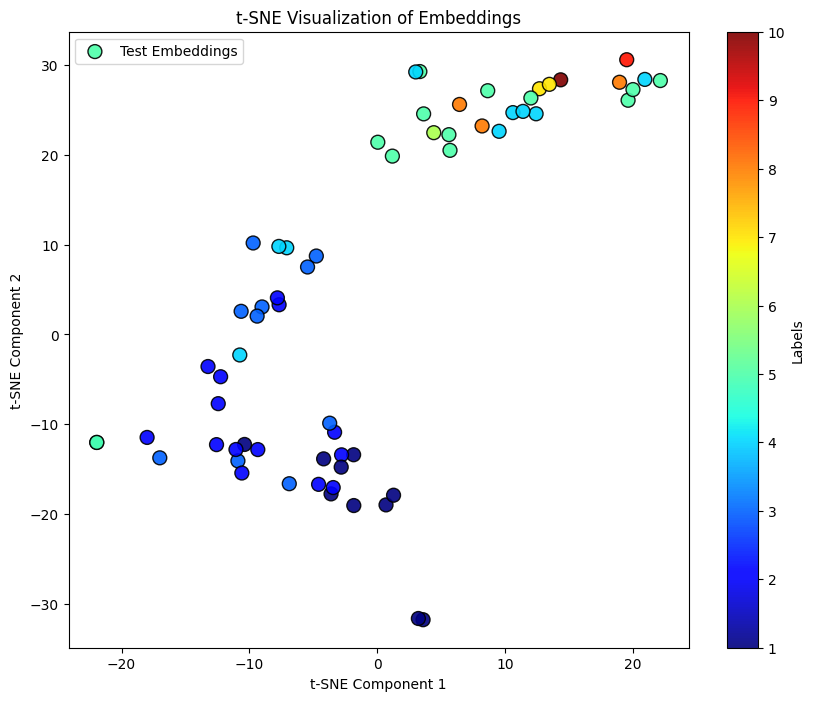

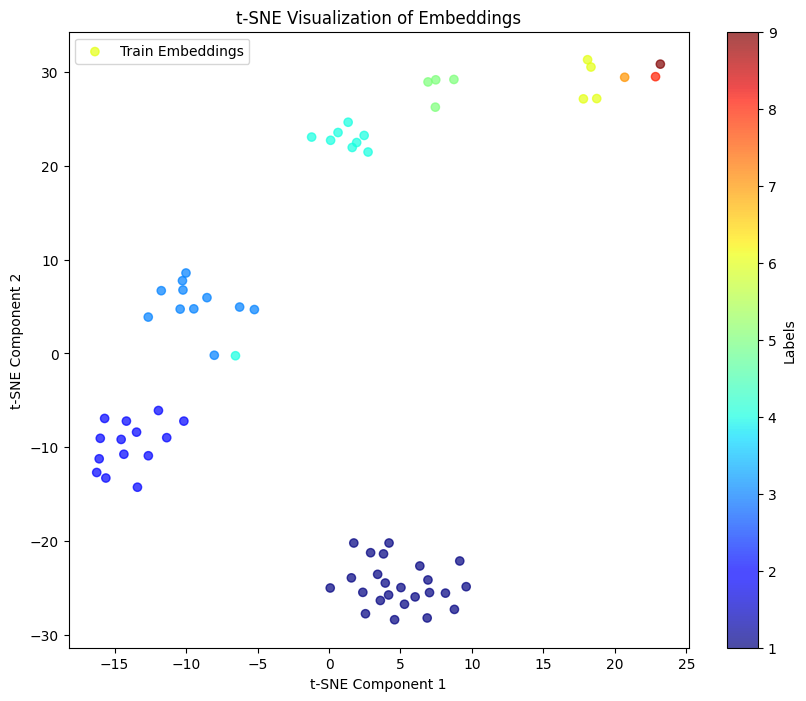

In [14]:
## SSS exp3 (clip with multimodal_cont)
train_feats_list, train_score_list, test_feats_list, test_score_list, text_feats, text_scores = get_feats_order_score('SimSurgSkill', depth=4, regressor='clip')
train_feats_list = F.normalize(train_feats_list, p=2, dim=-1)
test_feats_list = F.normalize(test_feats_list, p=2, dim=-1)
visualize_embeddings_normal(train_feats_list, train_score_list, perplexity=10)
visualize_embeddings_normal(test_feats_list, test_score_list, perplexity=10)
if text_feats is not None:
    visualize_embeddings_normal(text_feats[0], text_scores[0], perplexity=3)

# Combine text and image
combined_feats = torch.concat([test_feats_list.detach().cpu(), train_feats_list.detach().cpu()], dim=0)
combined_scores = torch.concat([test_score_list.detach().cpu(), train_score_list.detach().cpu()], dim=0)
visualize_embeddings(combined_feats, combined_scores, perplexity=10, split_index=len(test_feats_list))
visualize_embeddings_separately(combined_feats, combined_scores, 10, len(test_feats_list))

100%|██████████| 42/42 [00:02<00:00, 19.78it/s]
/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


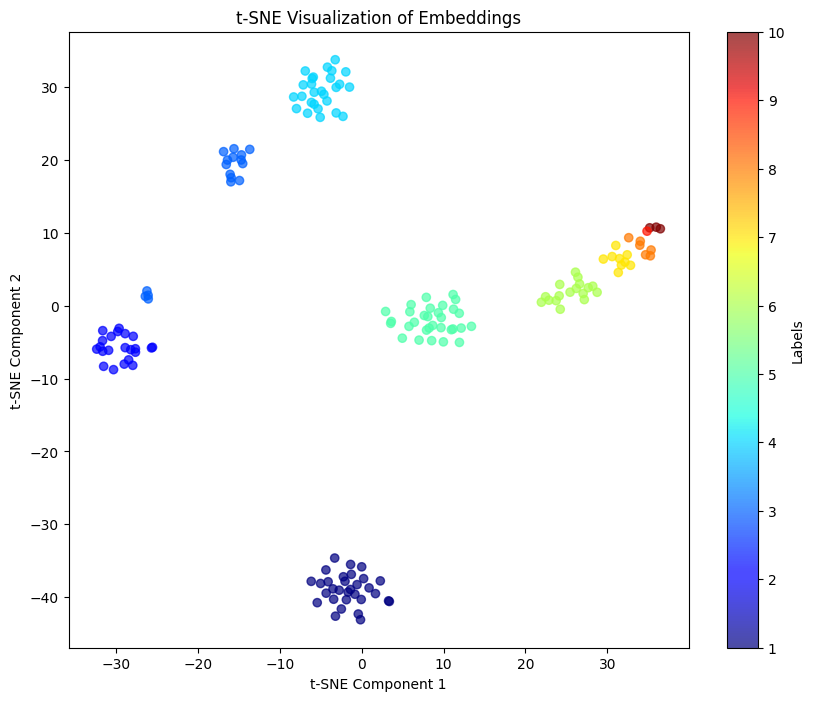

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


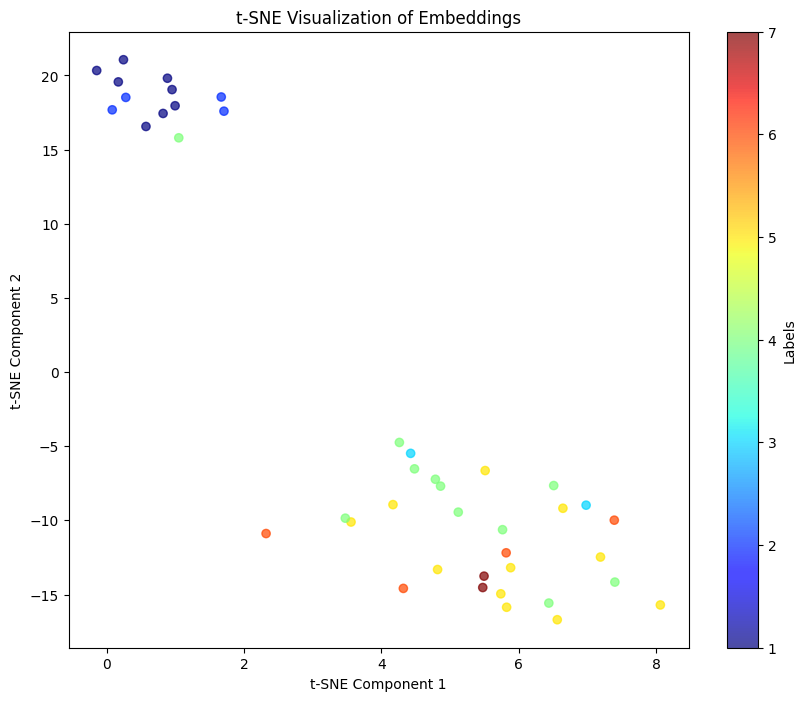

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


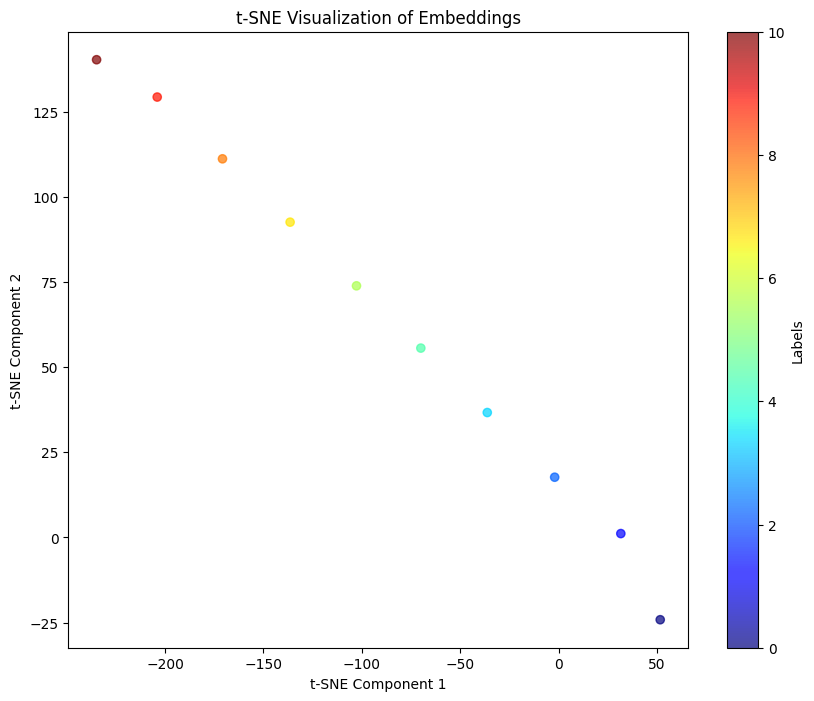

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


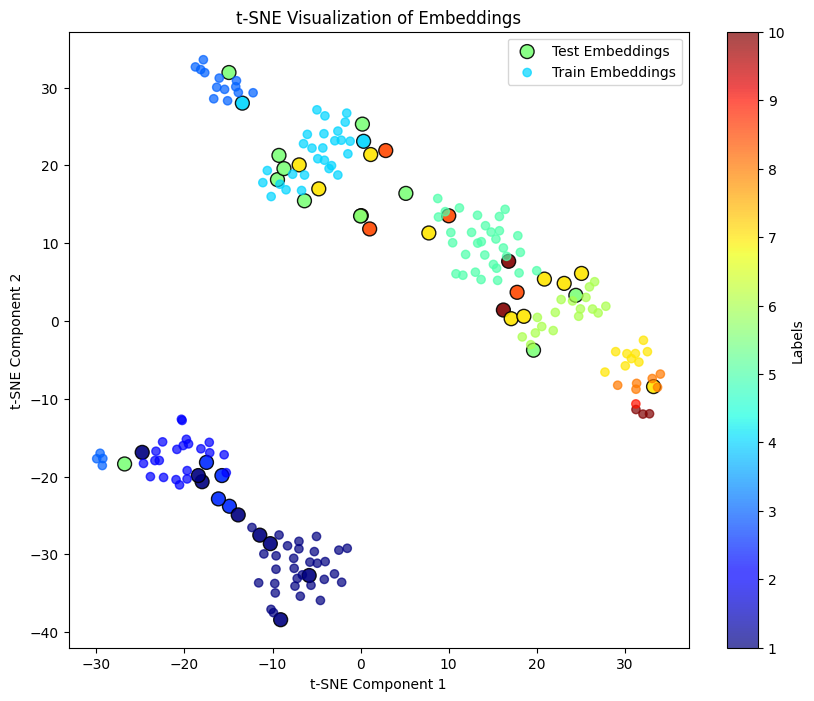

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


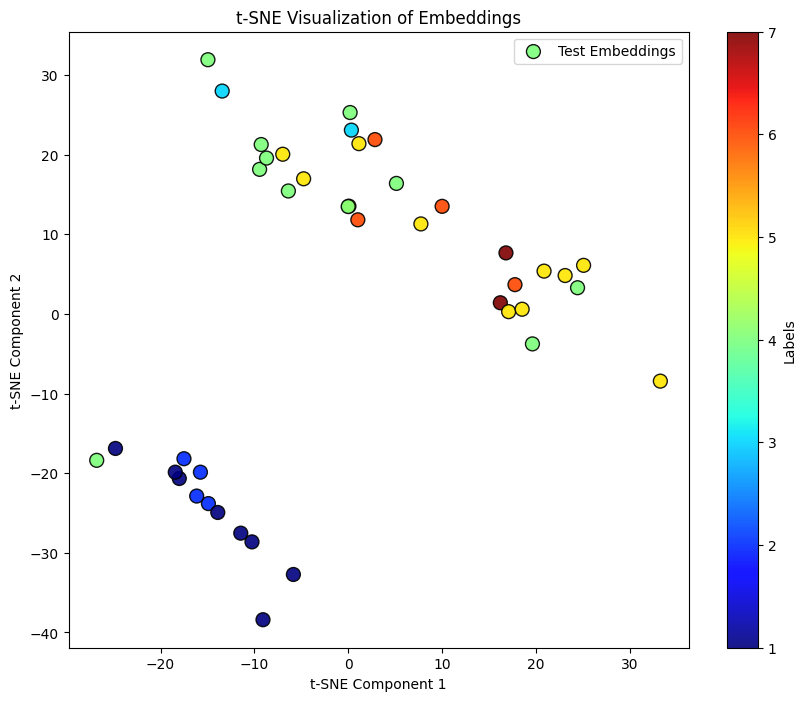

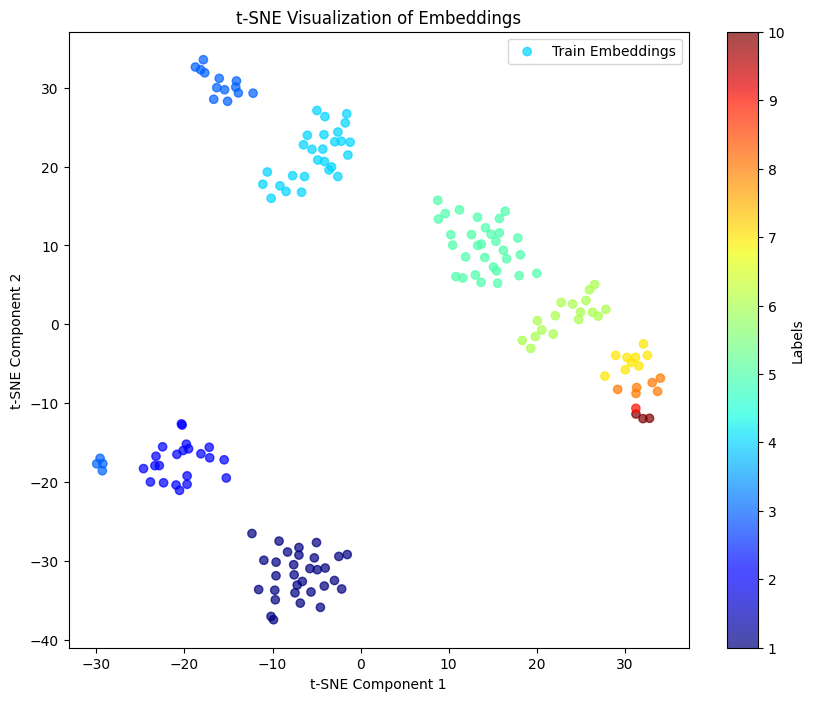

In [15]:
## ROSMA exp3 (clip with multimodal_cont)
train_feats_list, train_score_list, test_feats_list, test_score_list, text_feats, text_scores = get_feats_order_score('ROSMA', depth=4, regressor='clip')
train_feats_list = F.normalize(train_feats_list, p=2, dim=-1)
test_feats_list = F.normalize(test_feats_list, p=2, dim=-1)
visualize_embeddings_normal(train_feats_list, train_score_list, perplexity=10)
visualize_embeddings_normal(test_feats_list, test_score_list, perplexity=10)
if text_feats is not None:
    visualize_embeddings_normal(text_feats[0], text_scores[0], perplexity=3)

# Combine text and image
combined_feats = torch.concat([test_feats_list.detach().cpu(), train_feats_list.detach().cpu()], dim=0)
combined_scores = torch.concat([test_score_list.detach().cpu(), train_score_list.detach().cpu()], dim=0)
visualize_embeddings(combined_feats, combined_scores, perplexity=10, split_index=len(test_feats_list))
visualize_embeddings_separately(combined_feats, combined_scores, 10, len(test_feats_list))

100%|██████████| 43/43 [00:01<00:00, 26.21it/s]
/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


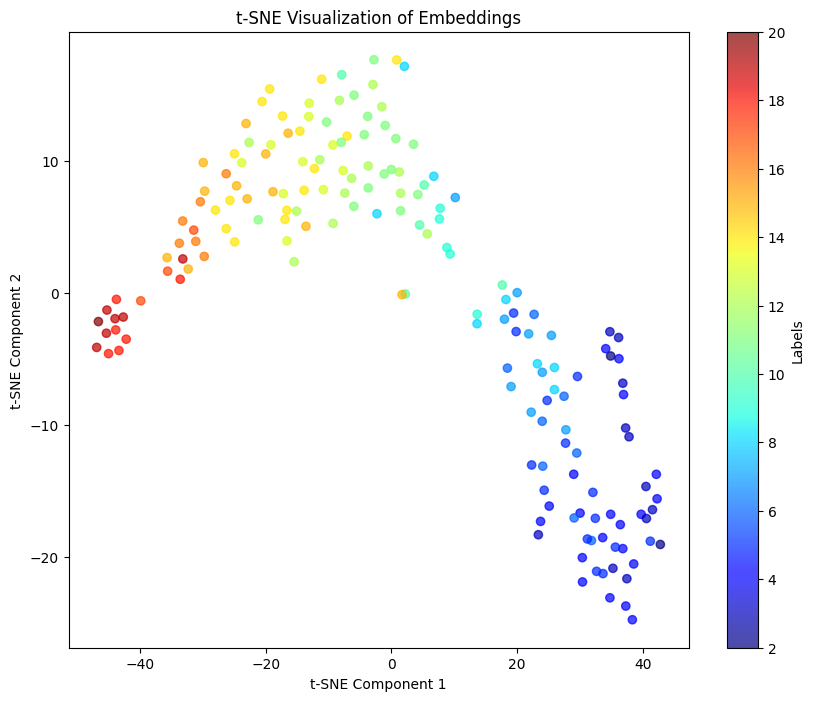

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


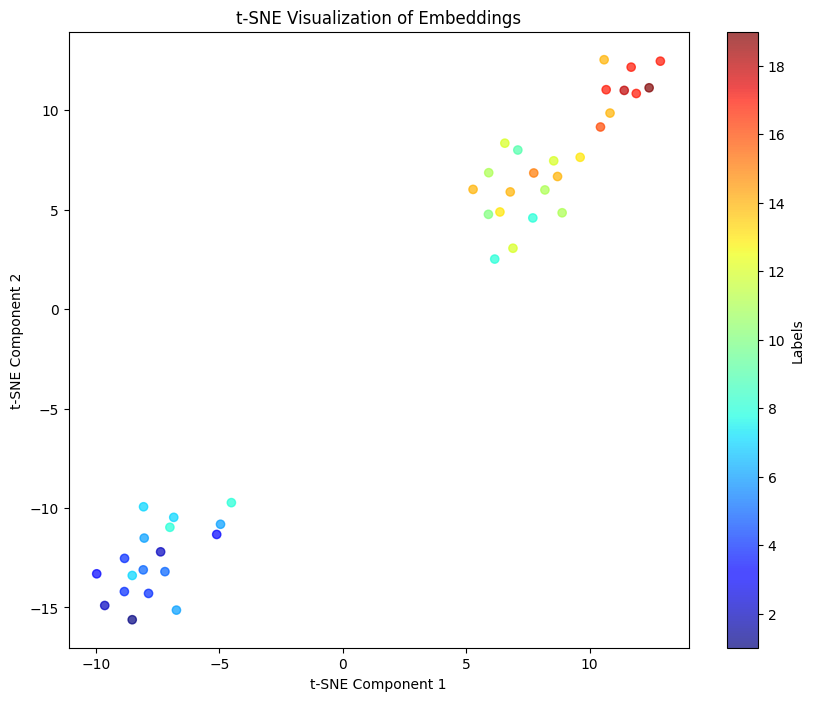

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


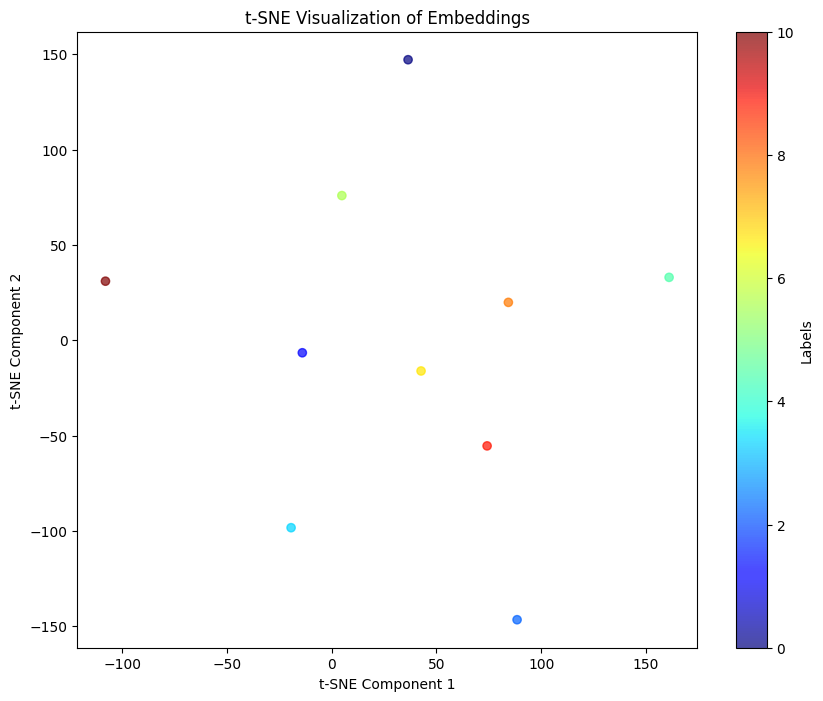

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


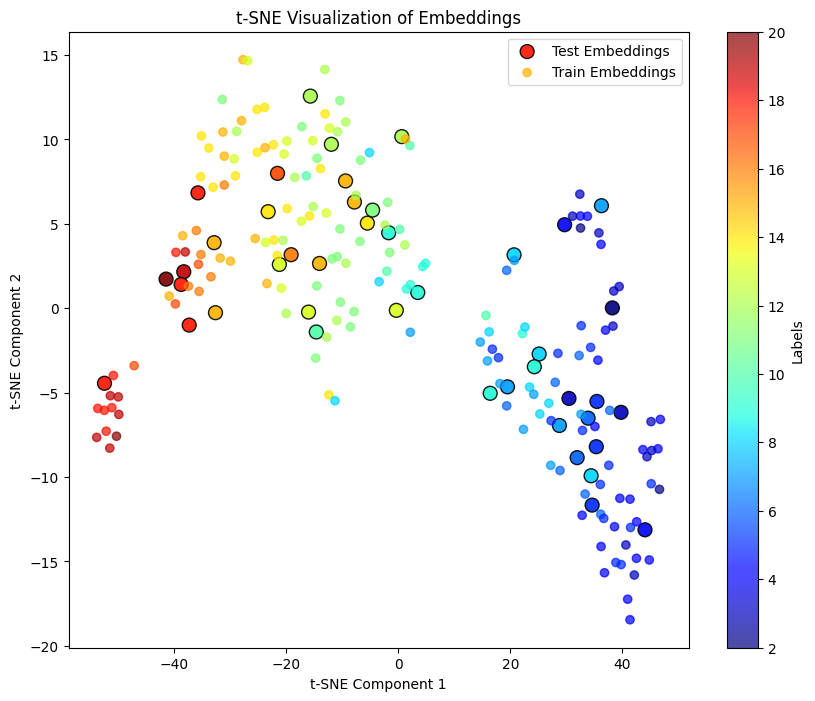

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


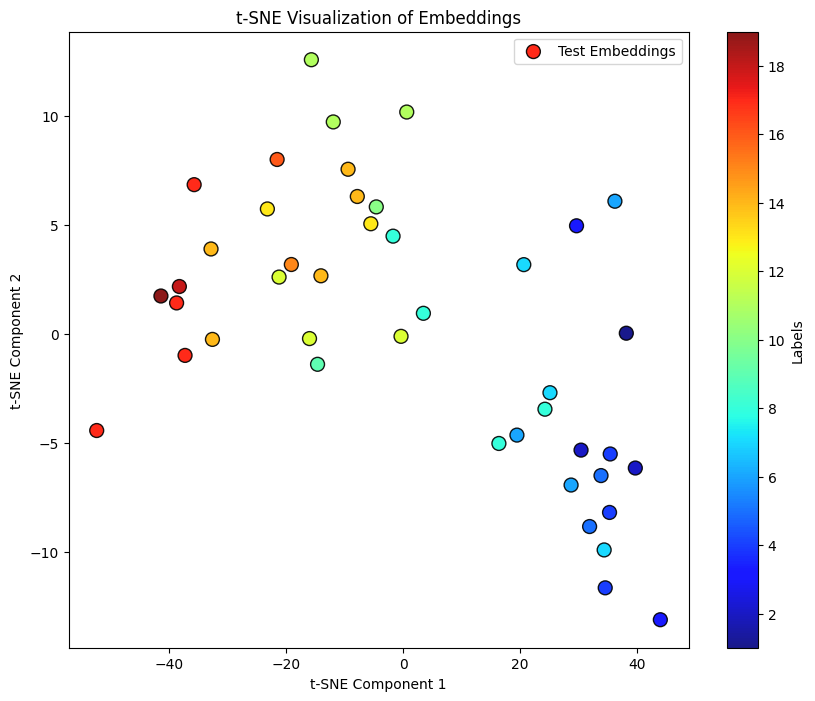

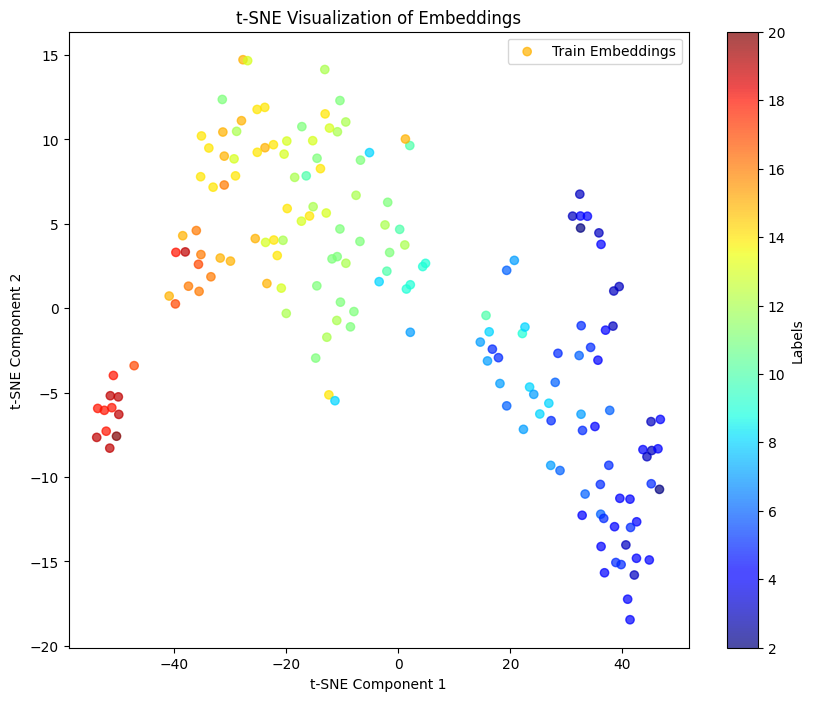

In [16]:
## NETS exp2 (clip with multimodal_cont)
train_feats_list, train_score_list, test_feats_list, test_score_list, text_feats, text_scores = get_feats_order_score('NETS', depth=4, regressor='clip', mm_cont=False)
train_feats_list = F.normalize(train_feats_list, p=2, dim=-1)
test_feats_list = F.normalize(test_feats_list, p=2, dim=-1)
visualize_embeddings_normal(train_feats_list, train_score_list, perplexity=10)
visualize_embeddings_normal(test_feats_list, test_score_list, perplexity=10)
if text_feats is not None:
    visualize_embeddings_normal(text_feats[0], text_scores[0], perplexity=3)

# Combine text and image
combined_feats = torch.concat([test_feats_list.detach().cpu(), train_feats_list.detach().cpu()], dim=0)
combined_scores = torch.concat([test_score_list.detach().cpu(), train_score_list.detach().cpu()], dim=0)
visualize_embeddings(combined_feats, combined_scores, perplexity=10, split_index=len(test_feats_list))
visualize_embeddings_separately(combined_feats, combined_scores, 10, len(test_feats_list))

100%|██████████| 64/64 [00:01<00:00, 39.59it/s]
/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


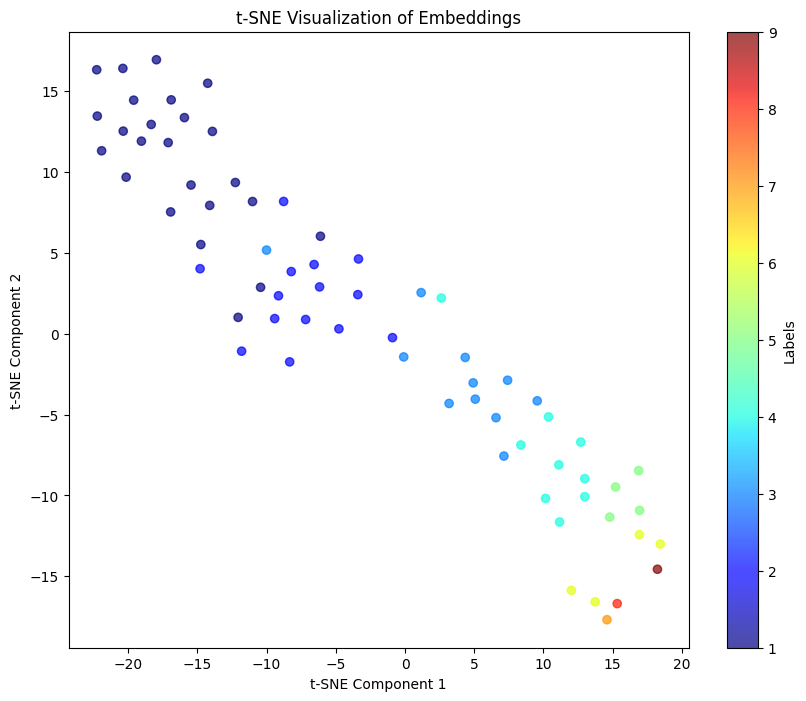

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


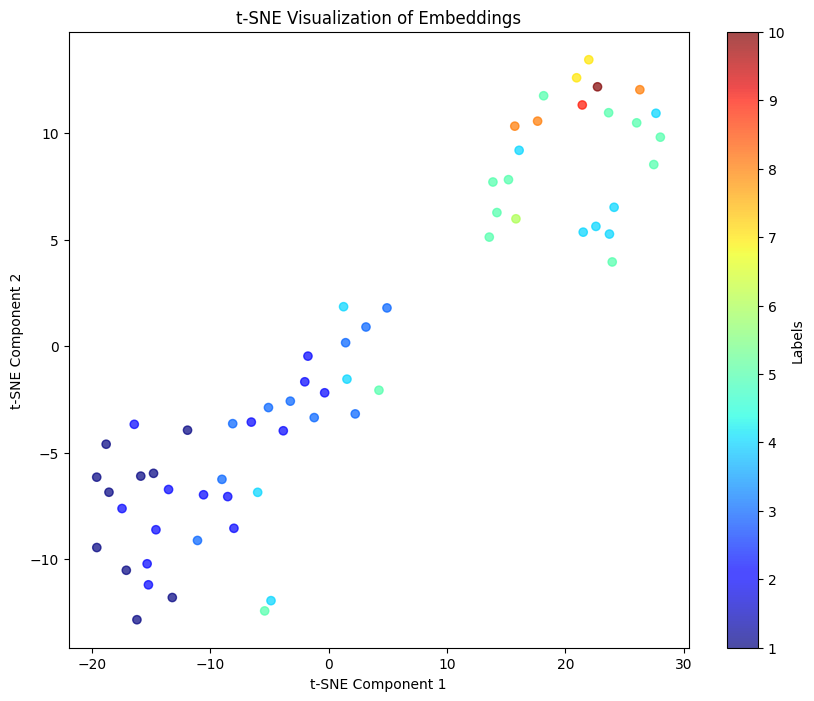

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


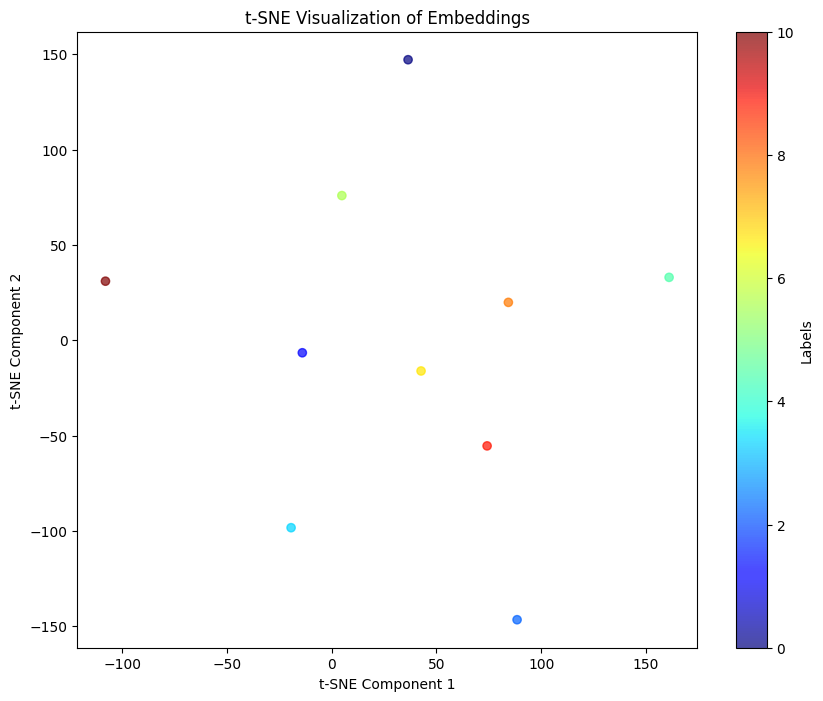

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


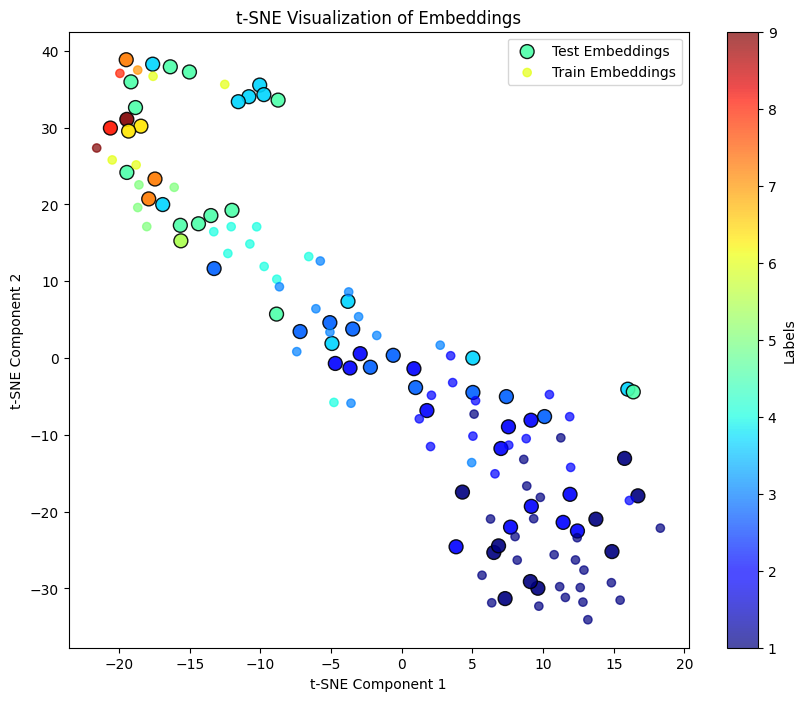

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


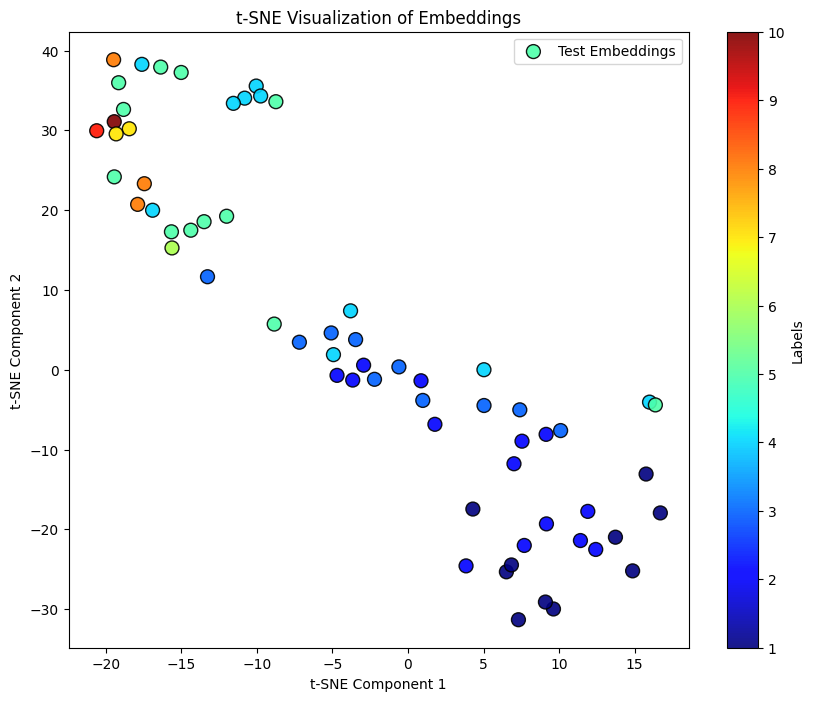

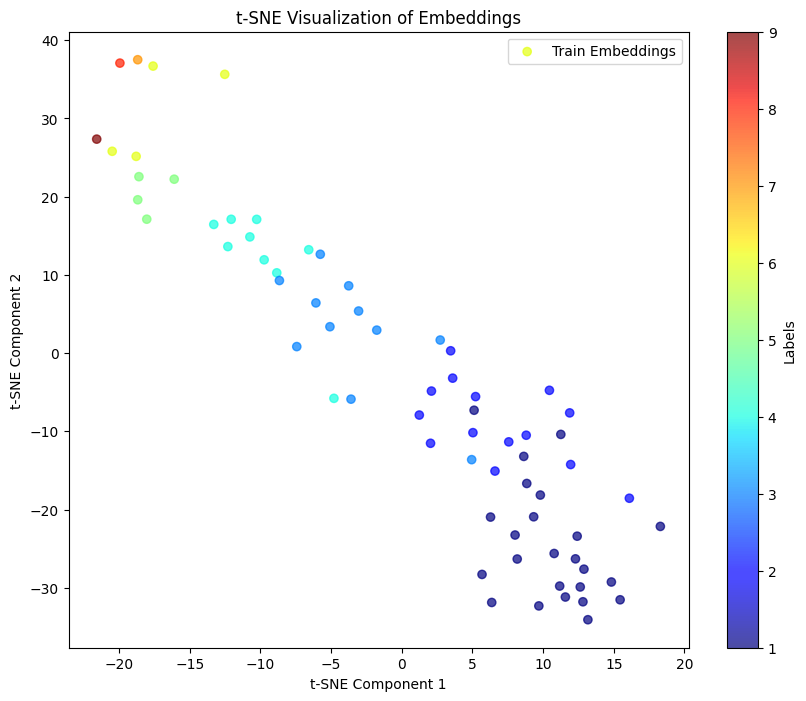

In [17]:
## SSS exp2 (clip with multimodal_cont)
train_feats_list, train_score_list, test_feats_list, test_score_list, text_feats, text_scores = get_feats_order_score('SimSurgSkill', depth=4, regressor='clip', mm_cont=False)
train_feats_list = F.normalize(train_feats_list, p=2, dim=-1)
test_feats_list = F.normalize(test_feats_list, p=2, dim=-1)
visualize_embeddings_normal(train_feats_list, train_score_list, perplexity=10)
visualize_embeddings_normal(test_feats_list, test_score_list, perplexity=10)
if text_feats is not None:
    visualize_embeddings_normal(text_feats[0], text_scores[0], perplexity=3)

# Combine text and image
combined_feats = torch.concat([test_feats_list.detach().cpu(), train_feats_list.detach().cpu()], dim=0)
combined_scores = torch.concat([test_score_list.detach().cpu(), train_score_list.detach().cpu()], dim=0)
visualize_embeddings(combined_feats, combined_scores, perplexity=10, split_index=len(test_feats_list))
visualize_embeddings_separately(combined_feats, combined_scores, 10, len(test_feats_list))

100%|██████████| 42/42 [00:02<00:00, 19.88it/s]
/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


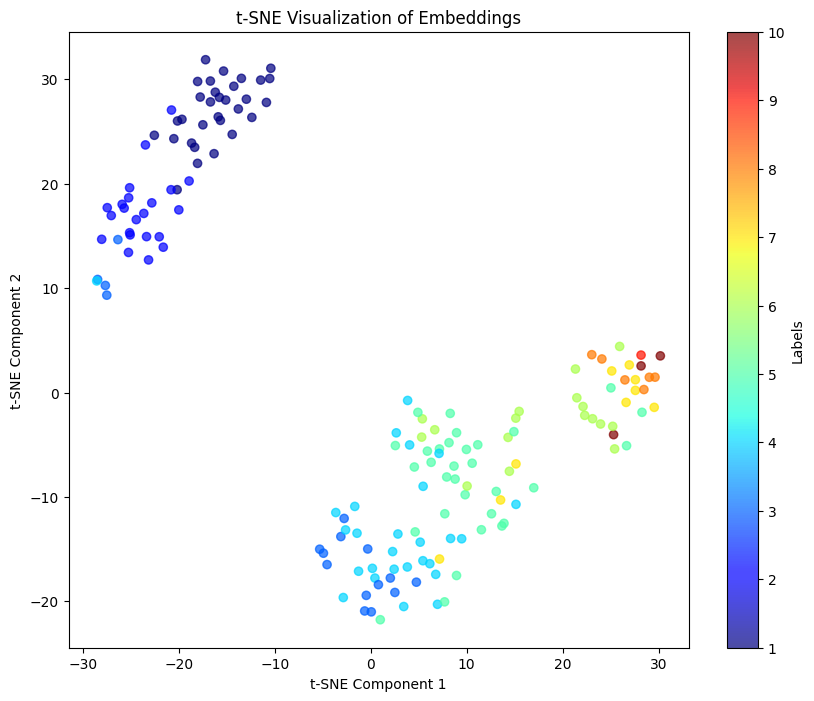

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


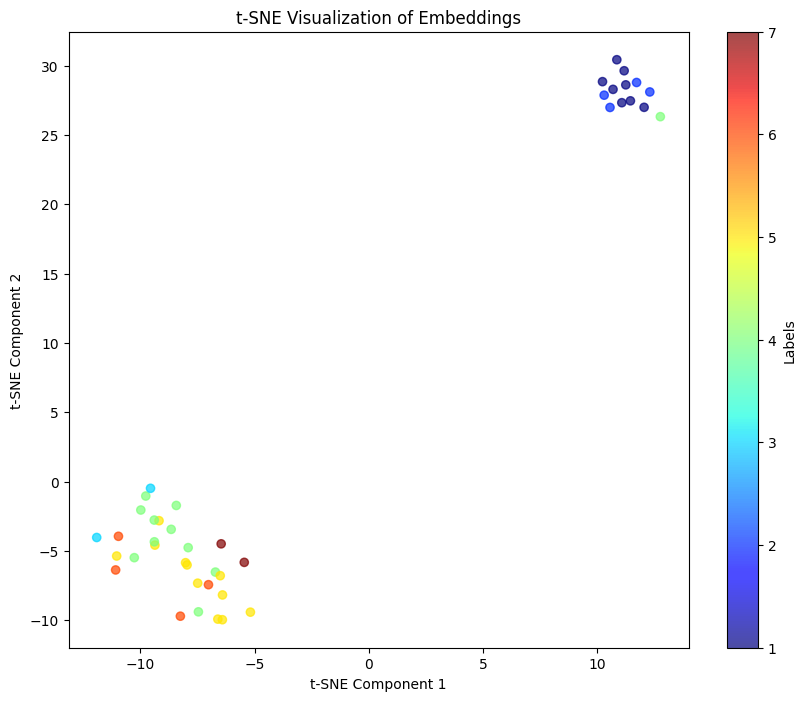

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


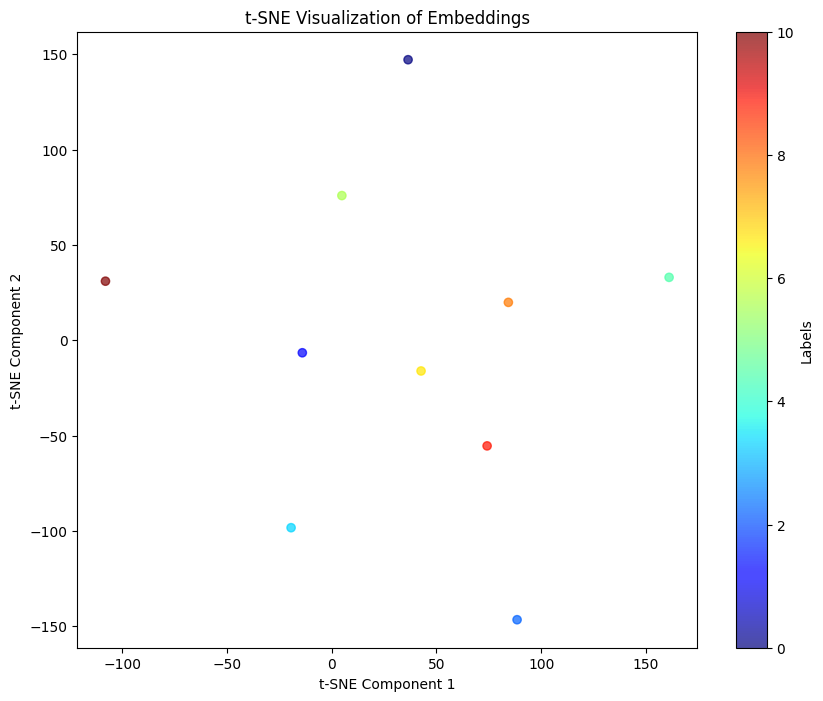

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


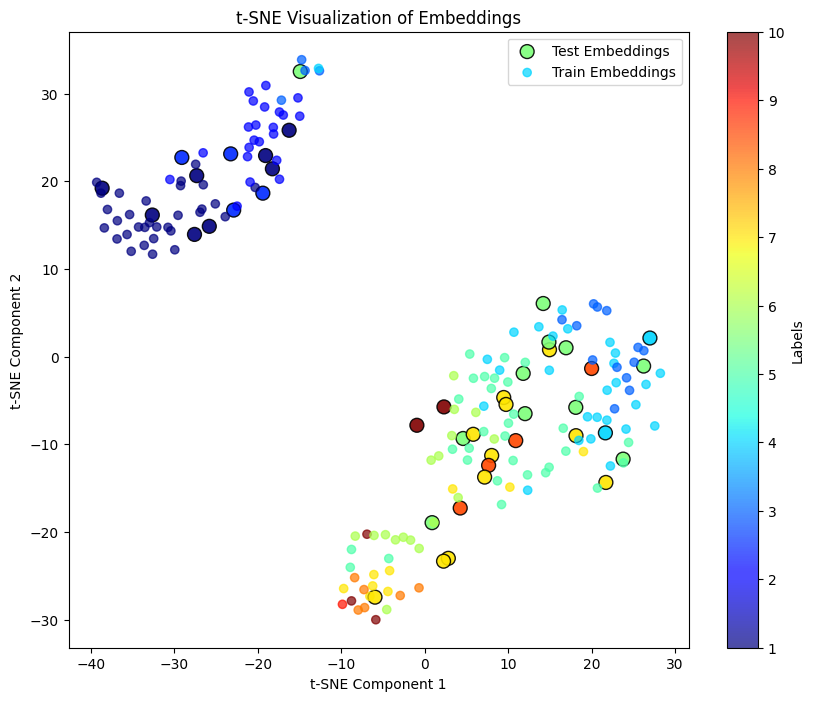

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


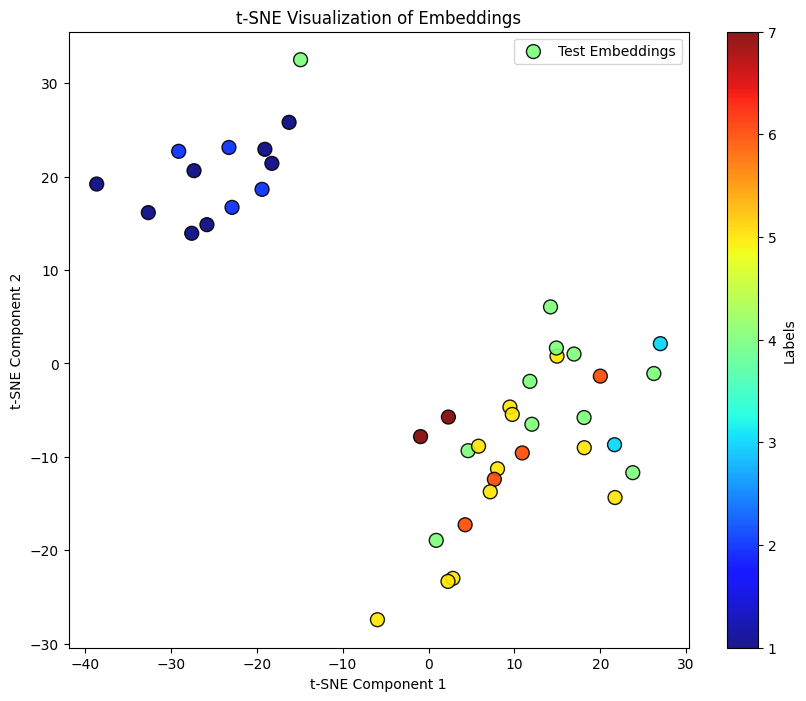

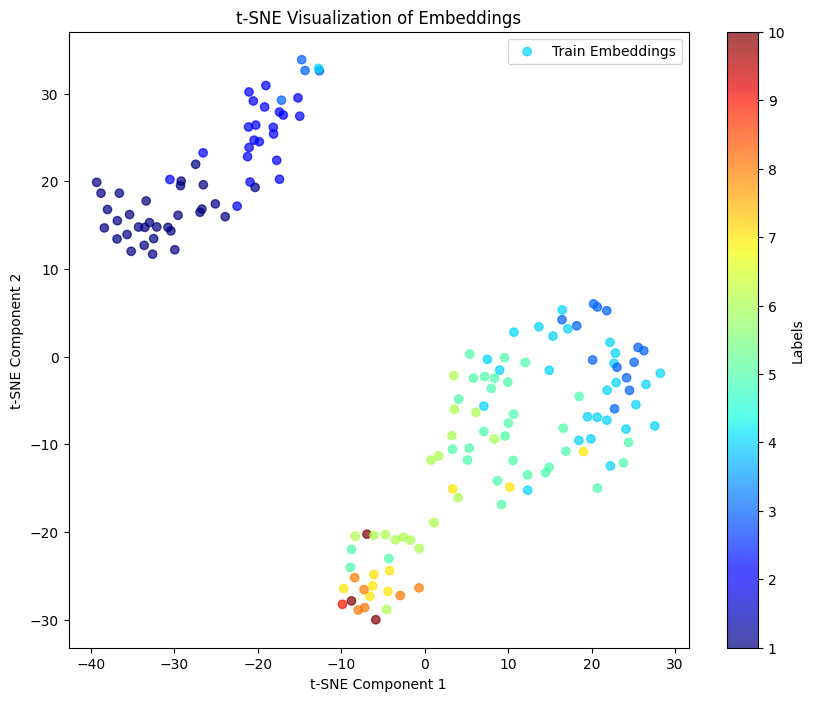

In [18]:
## ROSMA exp2 (clip with multimodal_cont)
train_feats_list, train_score_list, test_feats_list, test_score_list, text_feats, text_scores = get_feats_order_score('ROSMA', depth=4, regressor='clip', mm_cont=False)
train_feats_list = F.normalize(train_feats_list, p=2, dim=-1)
test_feats_list = F.normalize(test_feats_list, p=2, dim=-1)
visualize_embeddings_normal(train_feats_list, train_score_list, perplexity=10)
visualize_embeddings_normal(test_feats_list, test_score_list, perplexity=10)
if text_feats is not None:
    visualize_embeddings_normal(text_feats[0], text_scores[0], perplexity=3)

# Combine text and image
combined_feats = torch.concat([test_feats_list.detach().cpu(), train_feats_list.detach().cpu()], dim=0)
combined_scores = torch.concat([test_score_list.detach().cpu(), train_score_list.detach().cpu()], dim=0)
visualize_embeddings(combined_feats, combined_scores, perplexity=10, split_index=len(test_feats_list))
visualize_embeddings_separately(combined_feats, combined_scores, 10, len(test_feats_list))

100%|██████████| 43/43 [00:01<00:00, 22.01it/s]
/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


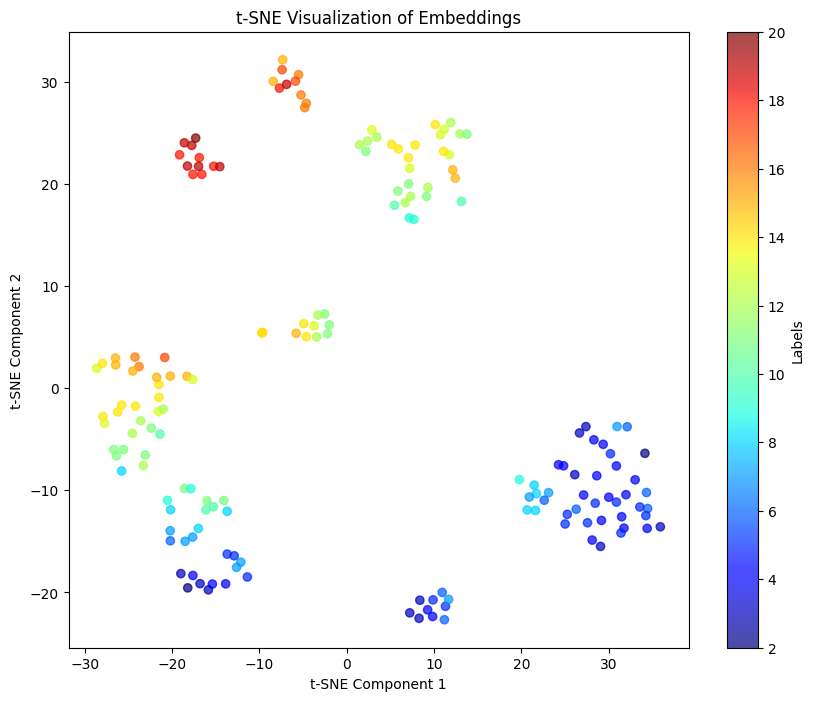

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


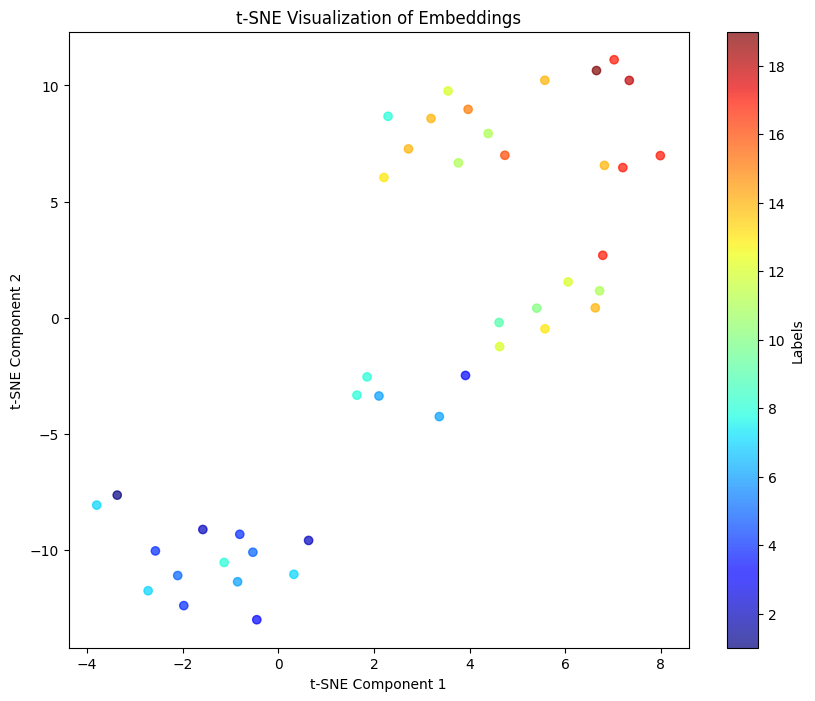

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


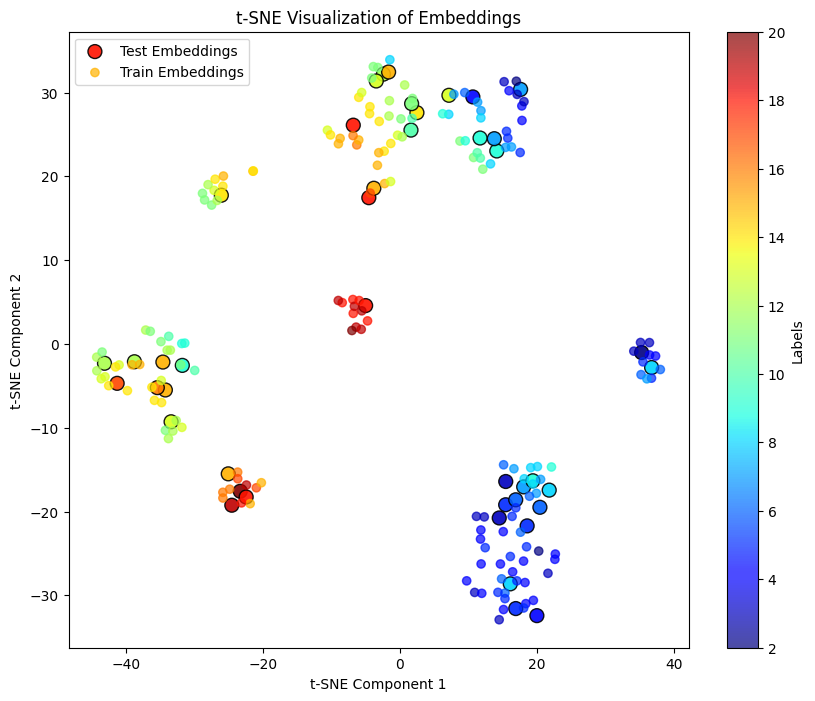

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


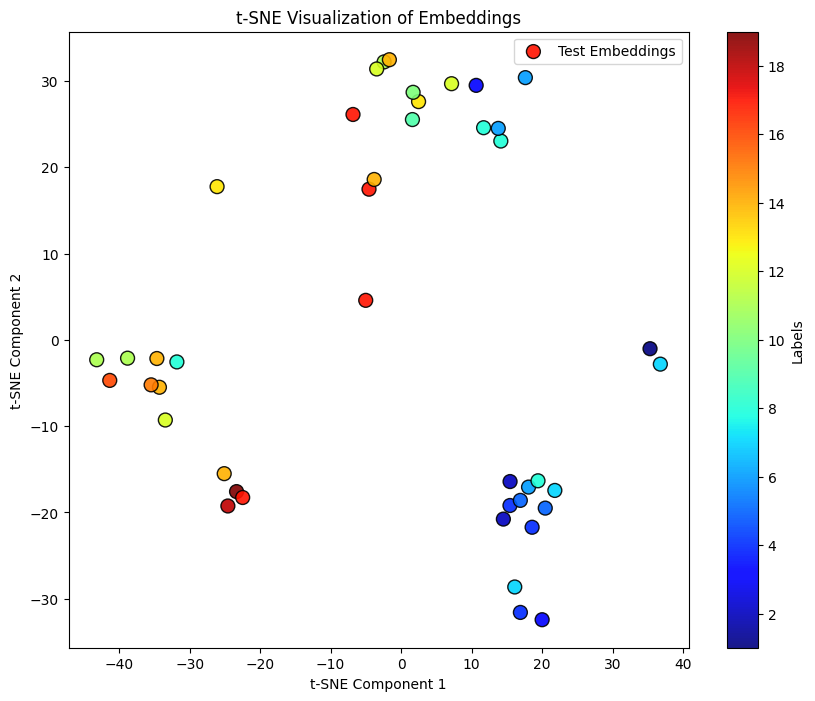

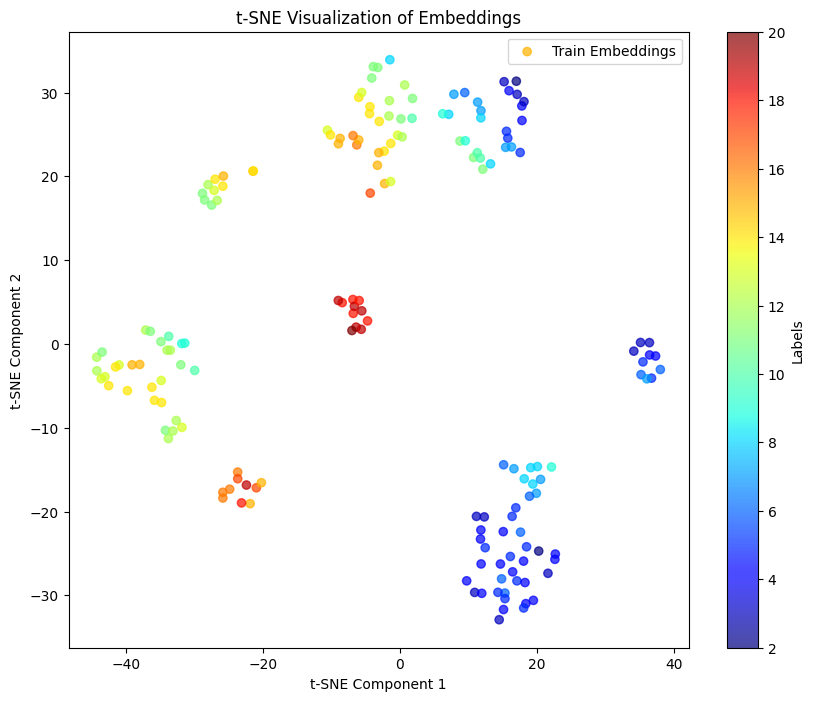

In [19]:
## NETS exp1
train_feats_list, train_score_list, test_feats_list, test_score_list, text_feats, text_scores = get_feats_order_score('NETS', depth=4, regressor='mlp')
train_feats_list = F.normalize(train_feats_list, p=2, dim=-1)
test_feats_list = F.normalize(test_feats_list, p=2, dim=-1)
visualize_embeddings_normal(train_feats_list, train_score_list, perplexity=10)
visualize_embeddings_normal(test_feats_list, test_score_list, perplexity=10)
if text_feats is not None:
    visualize_embeddings_normal(text_feats[0], text_scores[0], perplexity=3)

# Combine text and image
combined_feats = torch.concat([test_feats_list.detach().cpu(), train_feats_list.detach().cpu()], dim=0)
combined_scores = torch.concat([test_score_list.detach().cpu(), train_score_list.detach().cpu()], dim=0)
visualize_embeddings(combined_feats, combined_scores, perplexity=10, split_index=len(test_feats_list))
visualize_embeddings_separately(combined_feats, combined_scores, 10, len(test_feats_list))

  0%|          | 0/69 [00:00<?, ?it/s]

100%|██████████| 64/64 [00:01<00:00, 33.95it/s]
/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


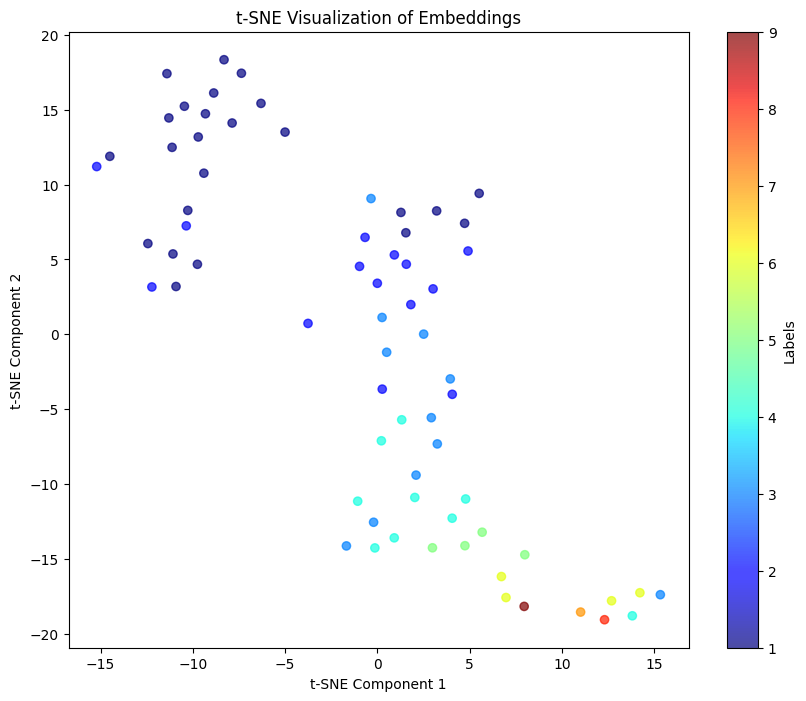

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


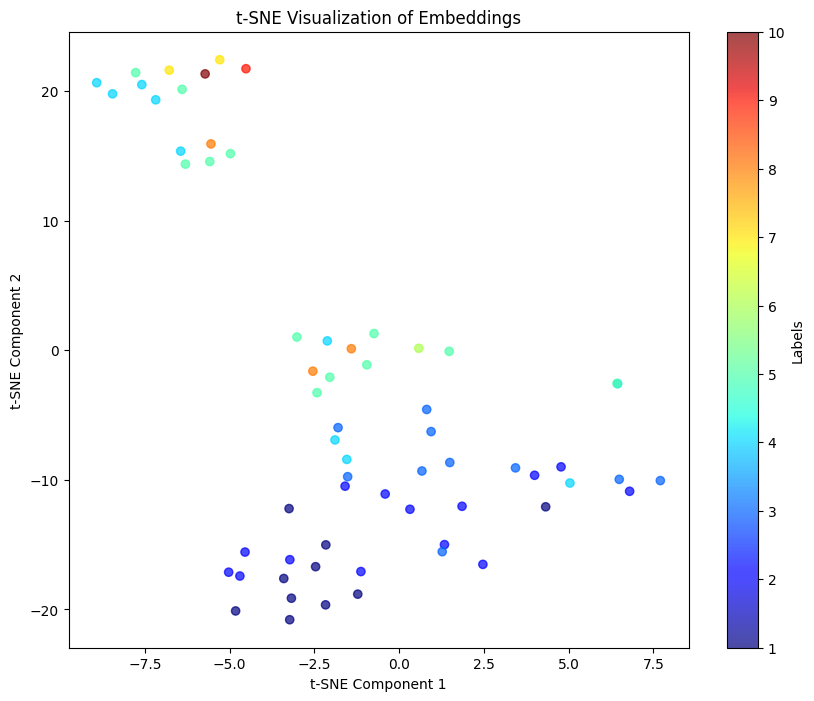

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


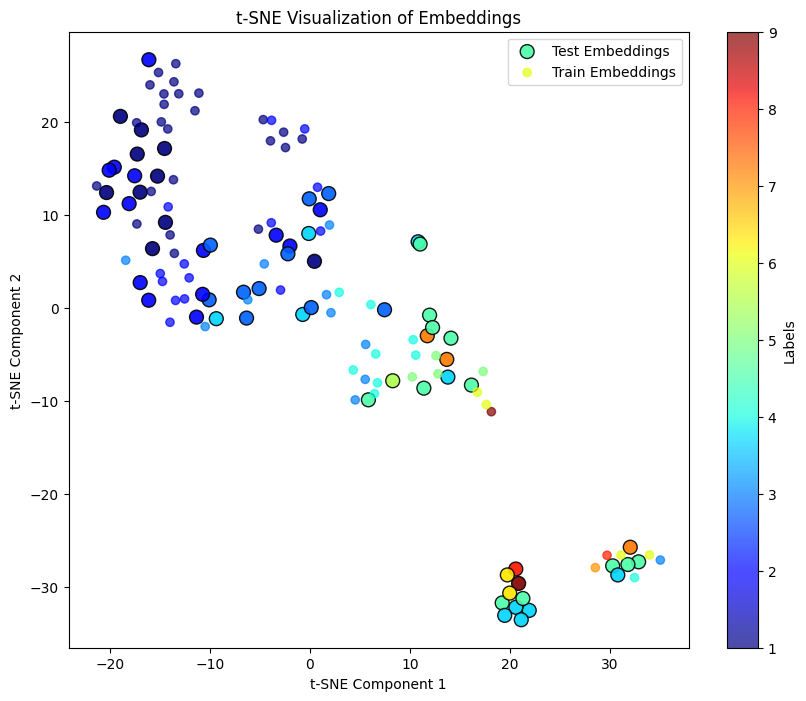

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


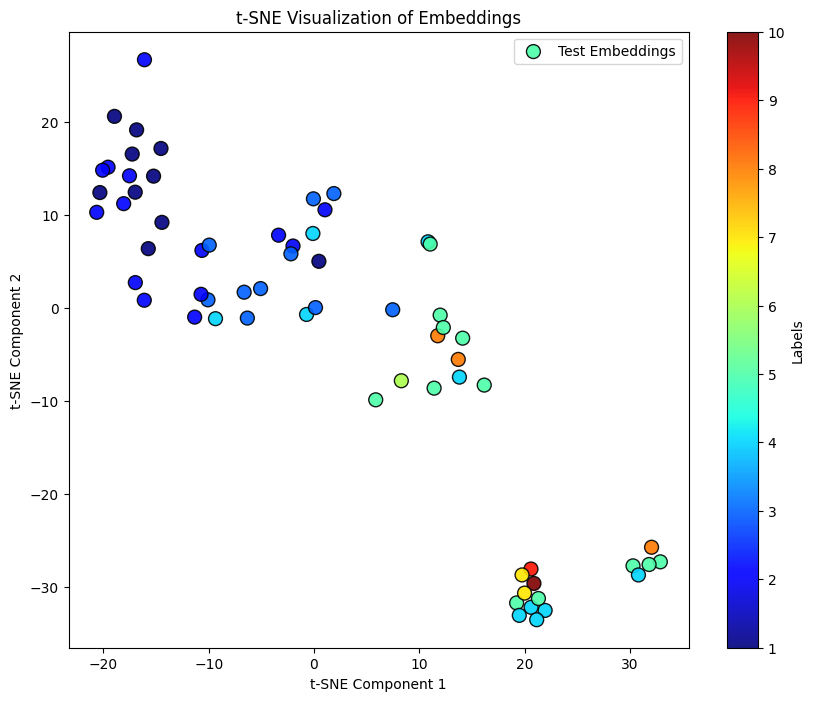

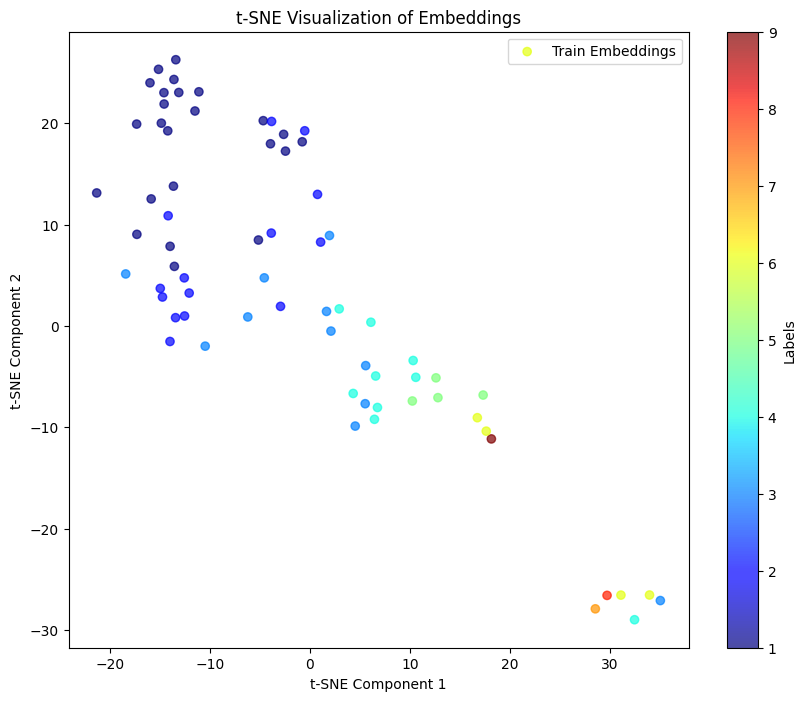

In [20]:
## SSS exp1
train_feats_list, train_score_list, test_feats_list, test_score_list, text_feats, text_scores = get_feats_order_score('SimSurgSkill', depth=4, regressor='mlp')
train_feats_list = F.normalize(train_feats_list, p=2, dim=-1)
test_feats_list = F.normalize(test_feats_list, p=2, dim=-1)
visualize_embeddings_normal(train_feats_list, train_score_list, perplexity=10)
visualize_embeddings_normal(test_feats_list, test_score_list, perplexity=10)
if text_feats is not None:
    visualize_embeddings_normal(text_feats[0], text_scores[0], perplexity=3)

# Combine text and image
combined_feats = torch.concat([test_feats_list.detach().cpu(), train_feats_list.detach().cpu()], dim=0)
combined_scores = torch.concat([test_score_list.detach().cpu(), train_score_list.detach().cpu()], dim=0)
visualize_embeddings(combined_feats, combined_scores, perplexity=10, split_index=len(test_feats_list))
visualize_embeddings_separately(combined_feats, combined_scores, 10, len(test_feats_list))

In [15]:
## ROSMA exp1
train_feats_list, train_score_list, test_feats_list, test_score_list, text_feats, text_scores = get_feats_order_score('ROSMA', depth=4, regressor='mlp')
train_feats_list = F.normalize(train_feats_list, p=2, dim=-1)
test_feats_list = F.normalize(test_feats_list, p=2, dim=-1)
visualize_embeddings_normal(train_feats_list, train_score_list, perplexity=10)
visualize_embeddings_normal(test_feats_list, test_score_list, perplexity=10)
if text_feats is not None:
    visualize_embeddings_normal(text_feats[0], text_scores[0], perplexity=3)

# Combine text and image
combined_feats = torch.concat([test_feats_list.detach().cpu(), train_feats_list.detach().cpu()], dim=0)
combined_scores = torch.concat([test_score_list.detach().cpu(), train_score_list.detach().cpu()], dim=0)
visualize_embeddings(combined_feats, combined_scores, perplexity=10, split_index=len(test_feats_list))

FileNotFoundError: [Errno 2] No such file or directory: 'results/ROSMA/0/VideoMAE-base-finetuned-kinetics/MM_cont_True/ckpt_regressor_mlp.pth'

100%|██████████| 64/64 [00:01<00:00, 35.56it/s]
/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


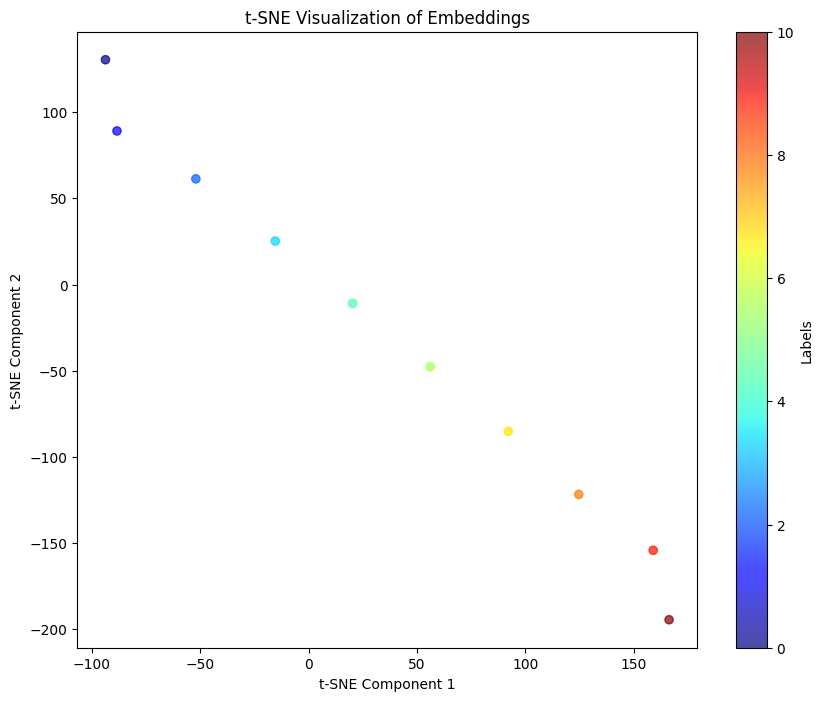

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


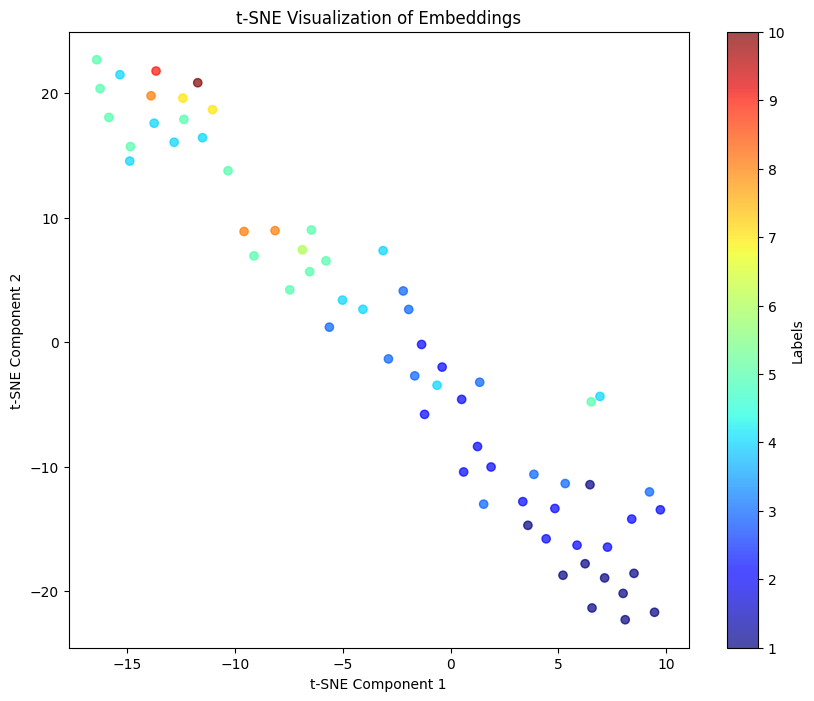

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


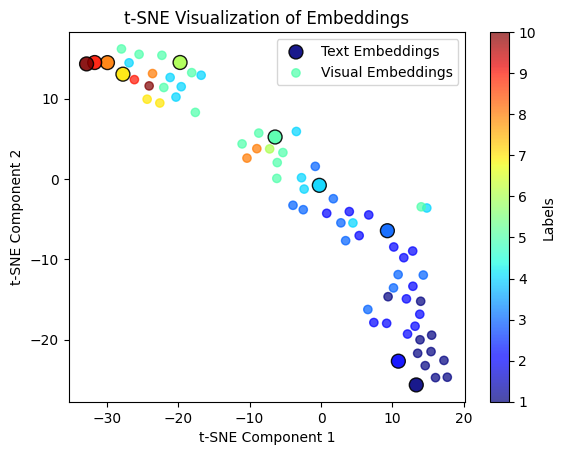

In [11]:
feats_list, score_list, text_feats, text_scores = get_feats_order_score('SimSurgSkill', depth=4)
feats_list = F.normalize(feats_list, p=2, dim=-1)
text_feats = F.normalize(text_feats, p=2, dim=-1)
combined_feats = torch.concat([text_feats[0].detach().cpu(), feats_list.detach().cpu()], dim=0)
combined_scores = torch.concat([text_scores[0].detach().cpu(), score_list.detach().cpu()], dim=0)
visualize_embeddings_normal(text_feats[0], text_scores[0], perplexity=3)
visualize_embeddings_normal(feats_list, score_list, perplexity=10)
visualize_embeddings(combined_feats, combined_scores, perplexity=10)

100%|██████████| 42/42 [00:01<00:00, 41.20it/s]
/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


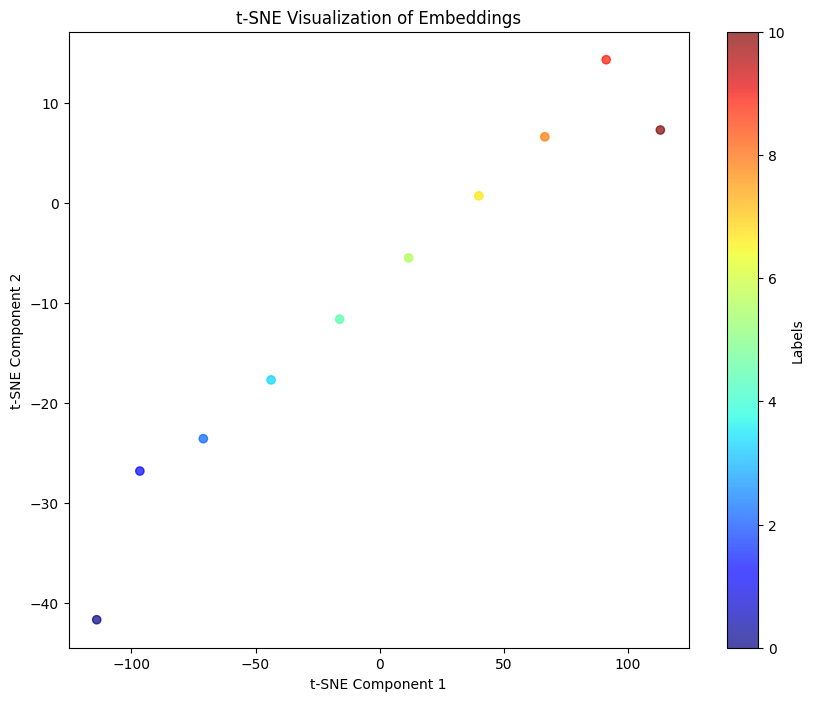

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


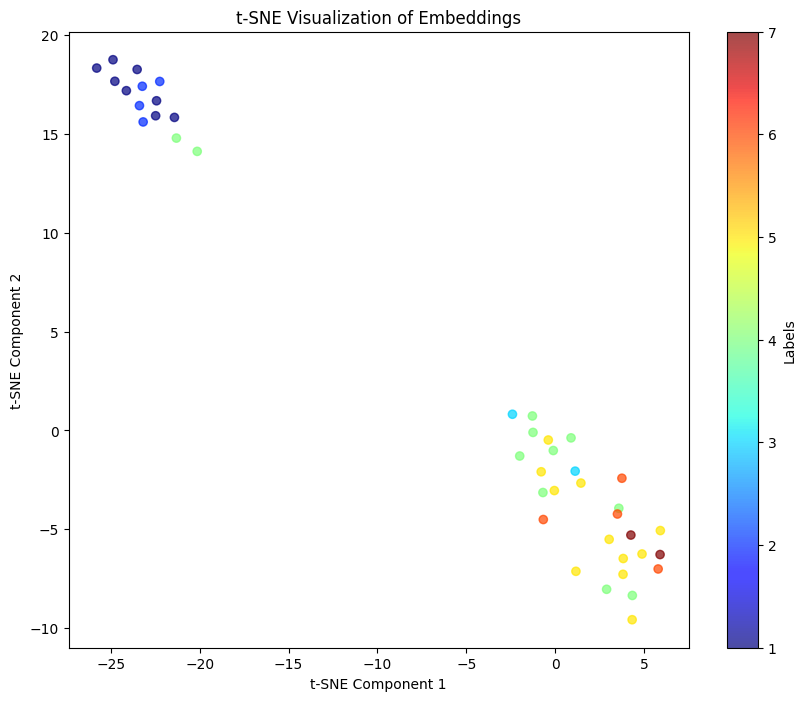

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


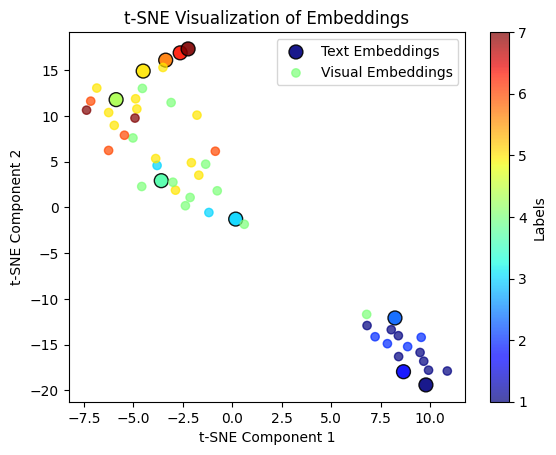

In [12]:
feats_list, score_list, text_feats, text_scores = get_feats_order_score('ROSMA', depth=4)
feats_list = F.normalize(feats_list, p=2, dim=-1)
text_feats = F.normalize(text_feats, p=2, dim=-1)
combined_feats = torch.concat([text_feats[0].detach().cpu(), feats_list.detach().cpu()], dim=0)
combined_scores = torch.concat([text_scores[0].detach().cpu(), score_list.detach().cpu()], dim=0)
visualize_embeddings_normal(text_feats[0], text_scores[0], perplexity=3)
visualize_embeddings_normal(feats_list, score_list, perplexity=10)
visualize_embeddings(combined_feats, combined_scores, perplexity=10)

100%|██████████| 43/43 [00:01<00:00, 41.10it/s]
/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


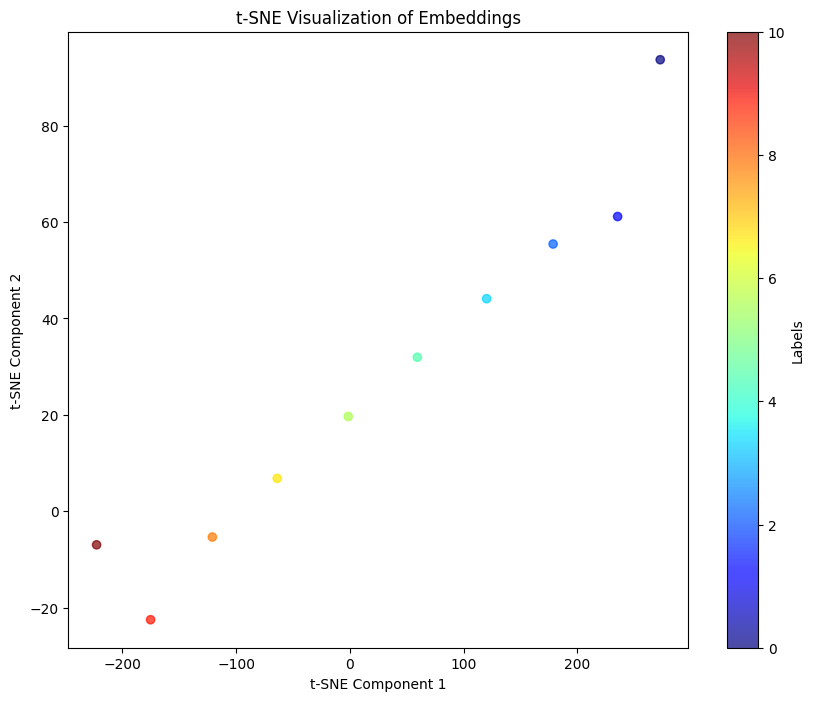

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


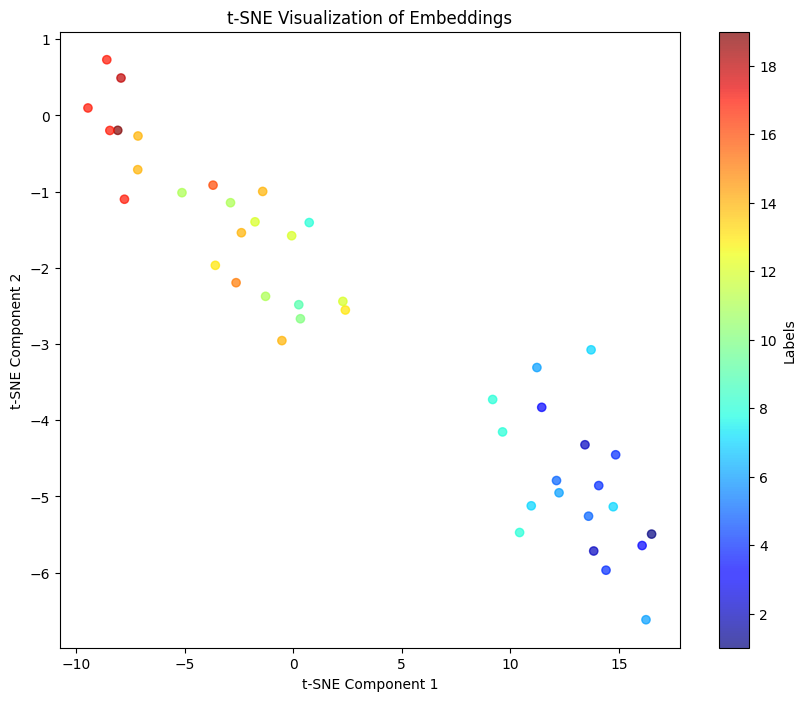

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


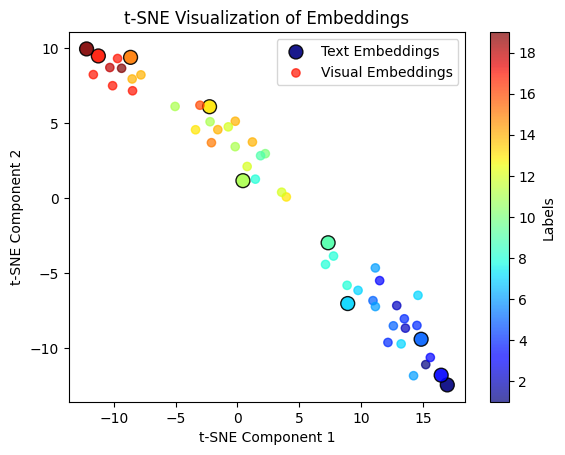

In [13]:
feats_list, score_list, text_feats, text_scores = get_feats_order_score('NETS', depth=4)
feats_list = F.normalize(feats_list, p=2, dim=-1)
text_feats = F.normalize(text_feats, p=2, dim=-1)
combined_feats = torch.concat([text_feats[0].detach().cpu(), feats_list.detach().cpu()], dim=0)
combined_scores = torch.concat([text_scores[0].detach().cpu(), score_list.detach().cpu()], dim=0)
visualize_embeddings_normal(text_feats[0], text_scores[0], perplexity=3)
visualize_embeddings_normal(feats_list, score_list, perplexity=10)
visualize_embeddings(combined_feats, combined_scores, perplexity=10)

100%|██████████| 42/42 [00:01<00:00, 21.80it/s]
/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


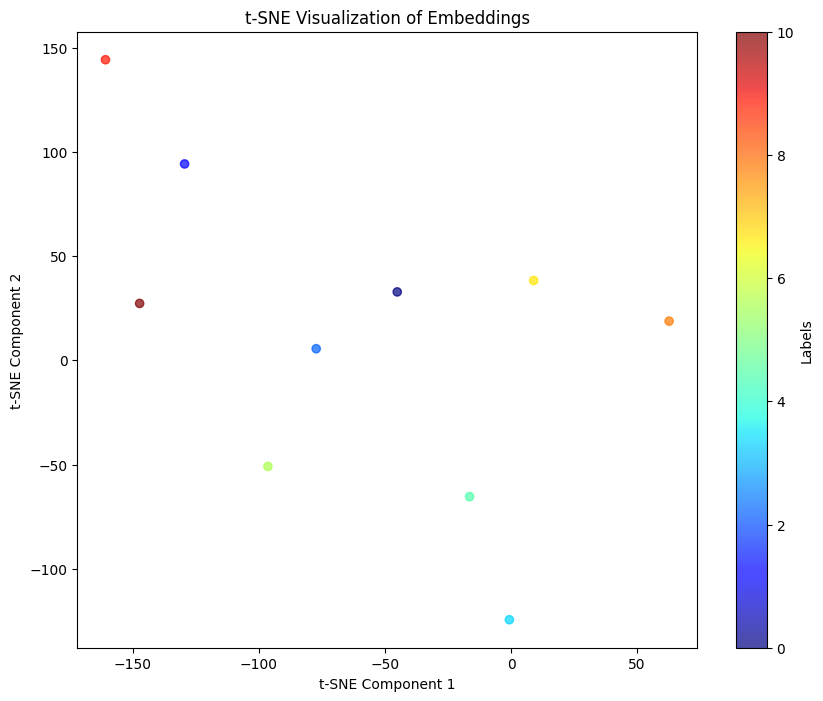

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


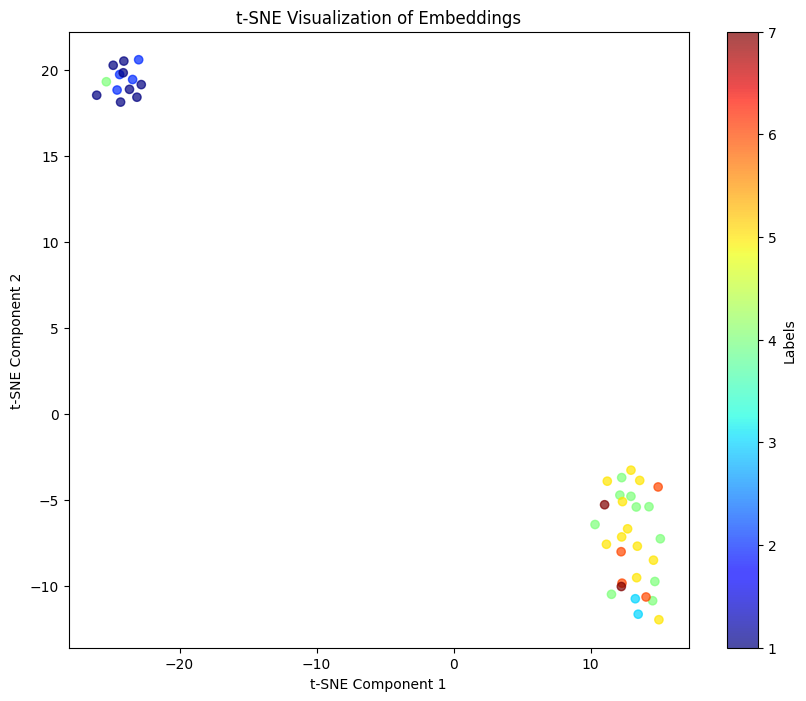

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


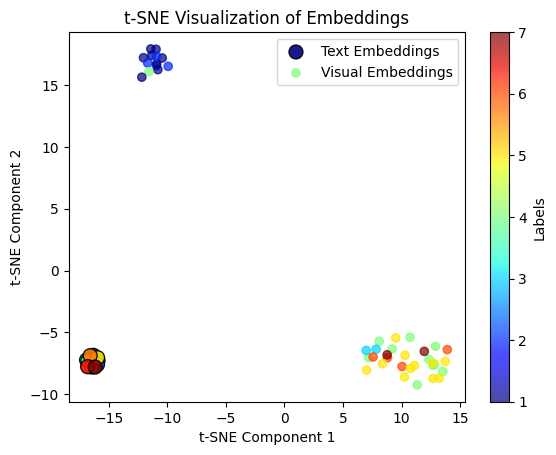

In [12]:
feats_list, score_list, text_feats, text_scores = get_feats_order_score('ROSMA', depth=4)
feats_list = F.normalize(feats_list, p=2, dim=-1)
text_feats = F.normalize(text_feats, p=2, dim=-1)
combined_feats = torch.concat([text_feats[0].detach().cpu(), feats_list.detach().cpu()], dim=0)
combined_scores = torch.concat([text_scores[0].detach().cpu(), score_list.detach().cpu()], dim=0)
visualize_embeddings_normal(text_feats[0], text_scores[0], perplexity=3)
visualize_embeddings_normal(feats_list, score_list, perplexity=10)
visualize_embeddings(combined_feats, combined_scores, perplexity=10)

100%|██████████| 64/64 [00:01<00:00, 39.09it/s]
/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


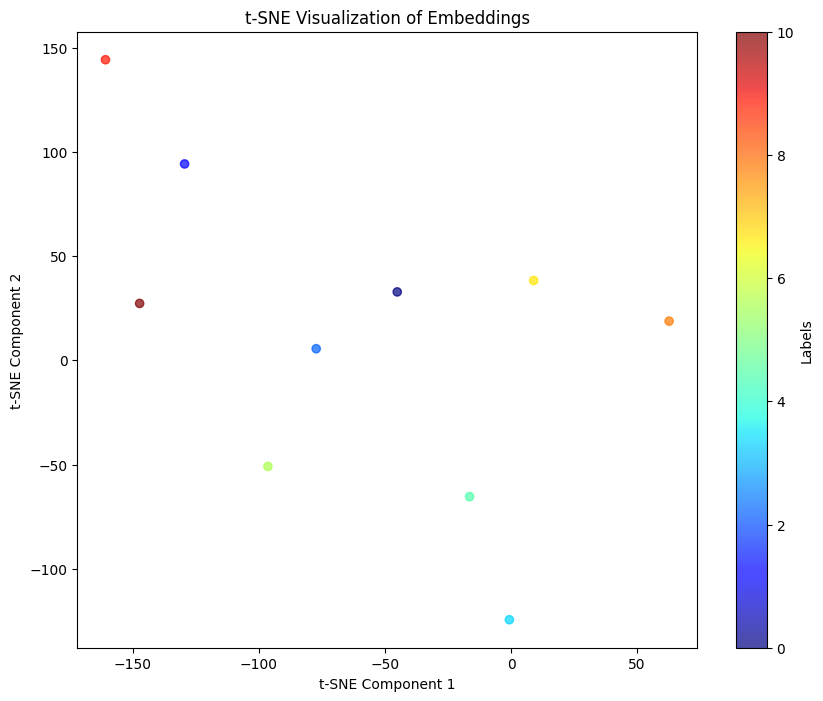

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


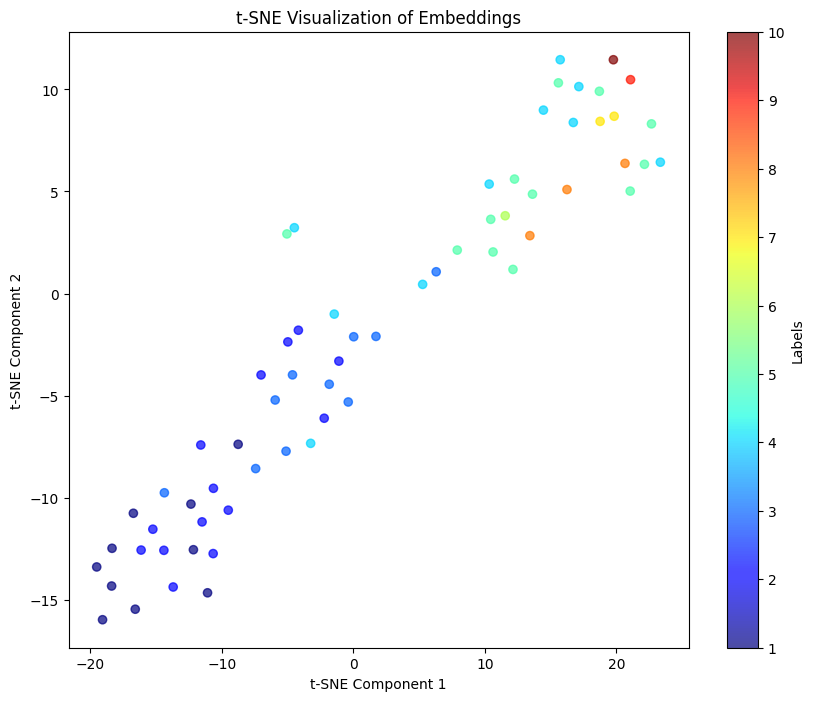

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


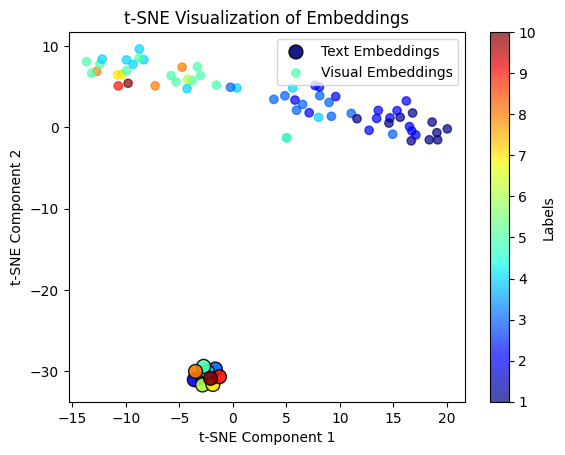

In [14]:
feats_list, score_list, text_feats, text_scores = get_feats_order_score('SimSurgSkill', depth=4)
feats_list = F.normalize(feats_list, p=2, dim=-1)
text_feats = F.normalize(text_feats, p=2, dim=-1)
combined_feats = torch.concat([text_feats[0].detach().cpu(), feats_list.detach().cpu()], dim=0)
combined_scores = torch.concat([text_scores[0].detach().cpu(), score_list.detach().cpu()], dim=0)
visualize_embeddings_normal(text_feats[0], text_scores[0], perplexity=3)
visualize_embeddings_normal(feats_list, score_list, perplexity=10)
visualize_embeddings(combined_feats, combined_scores, perplexity=10)

100%|██████████| 42/42 [00:01<00:00, 33.11it/s]
/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


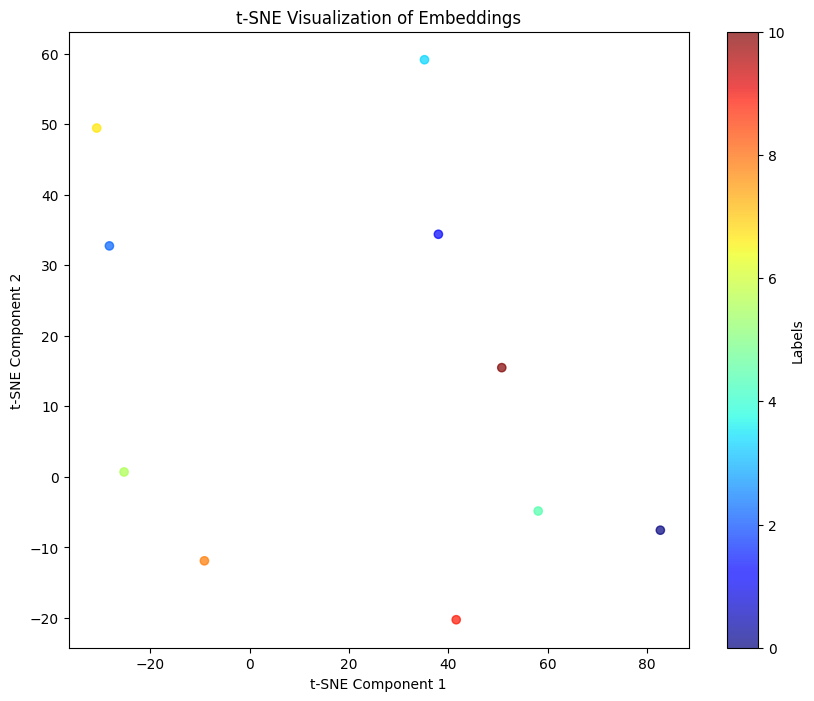

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


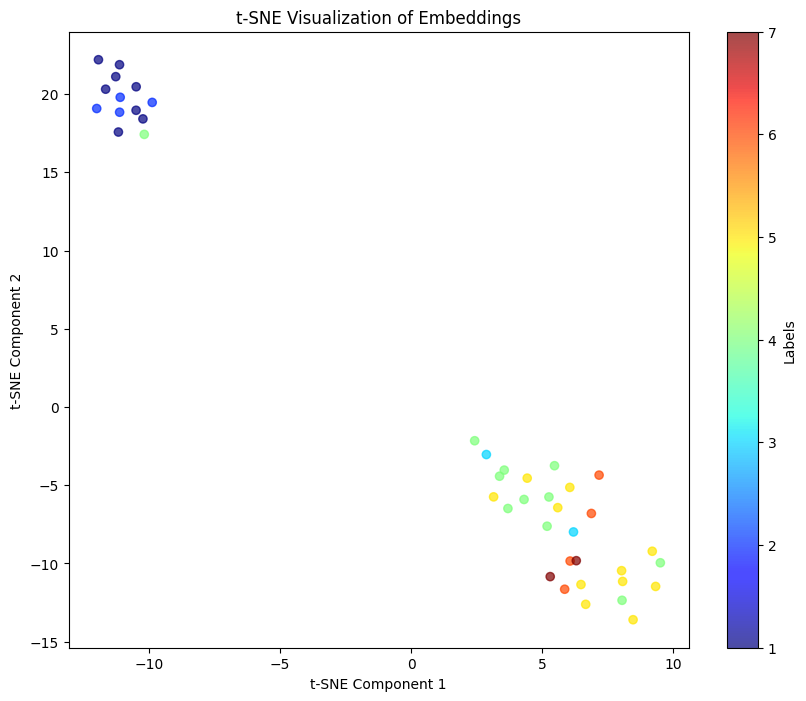

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


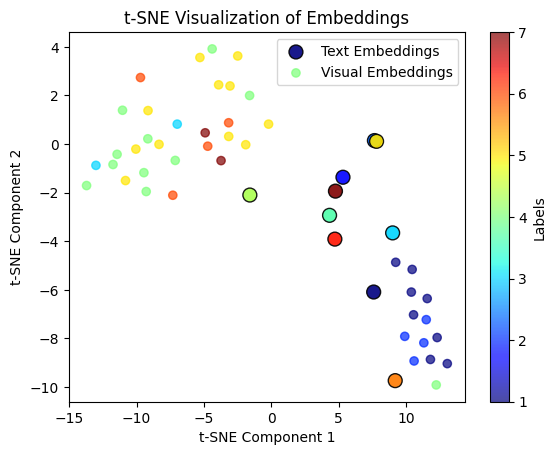

In [14]:
feats_list, score_list, text_feats, text_scores = get_feats_order_score('ROSMA', depth=4)
feats_list = F.normalize(feats_list, p=2, dim=-1)
text_feats = F.normalize(text_feats, p=2, dim=-1)
combined_feats = torch.concat([text_feats[0].detach().cpu(), feats_list.detach().cpu()], dim=0)
combined_scores = torch.concat([text_scores[0].detach().cpu(), score_list.detach().cpu()], dim=0)
visualize_embeddings_normal(text_feats[0], text_scores[0], perplexity=3)
visualize_embeddings_normal(feats_list, score_list, perplexity=10)
visualize_embeddings(combined_feats, combined_scores, perplexity=10)

100%|██████████| 64/64 [00:01<00:00, 37.03it/s]
/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


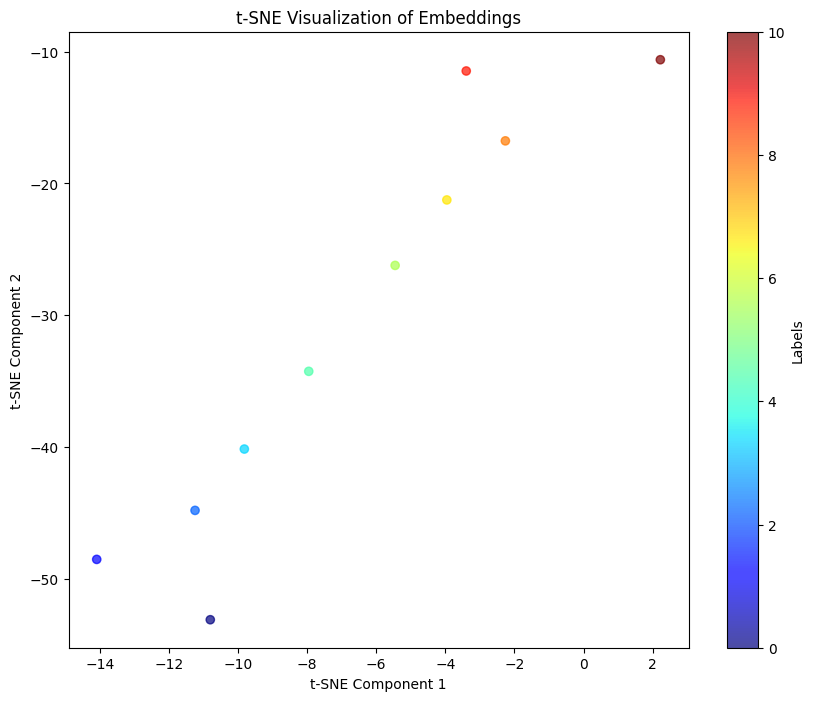

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


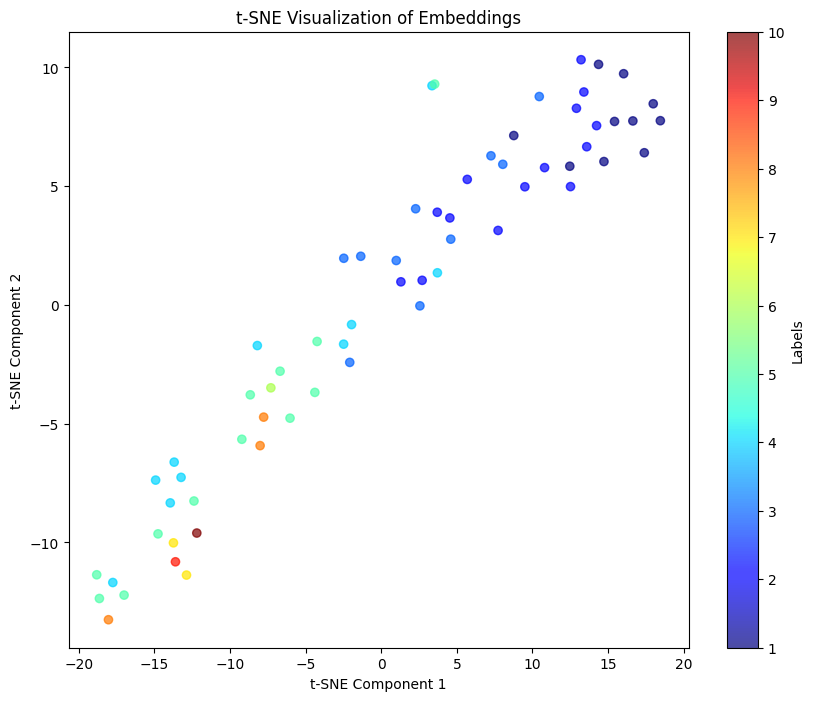

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


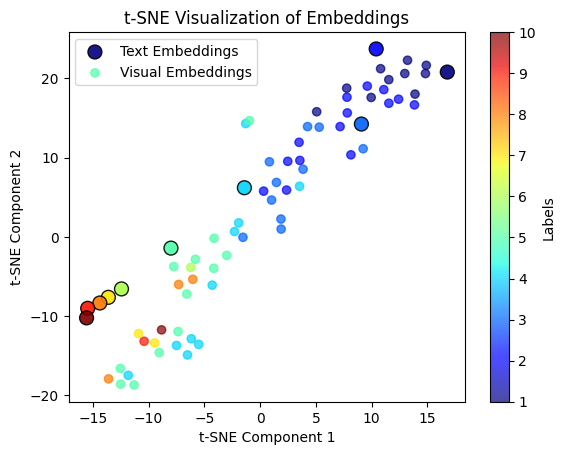

In [11]:
feats_list, score_list, text_feats, text_scores = get_feats_order_score('SimSurgSkill', depth=4)
feats_list = F.normalize(feats_list, p=2, dim=-1)
text_feats = F.normalize(text_feats, p=2, dim=-1)
combined_feats = torch.concat([text_feats[0].detach().cpu(), feats_list.detach().cpu()], dim=0)
combined_scores = torch.concat([text_scores[0].detach().cpu(), score_list.detach().cpu()], dim=0)
visualize_embeddings_normal(text_feats[0], text_scores[0], perplexity=3)
visualize_embeddings_normal(feats_list, score_list, perplexity=10)
visualize_embeddings(combined_feats, combined_scores, perplexity=10)

100%|██████████| 43/43 [00:01<00:00, 30.10it/s]
/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


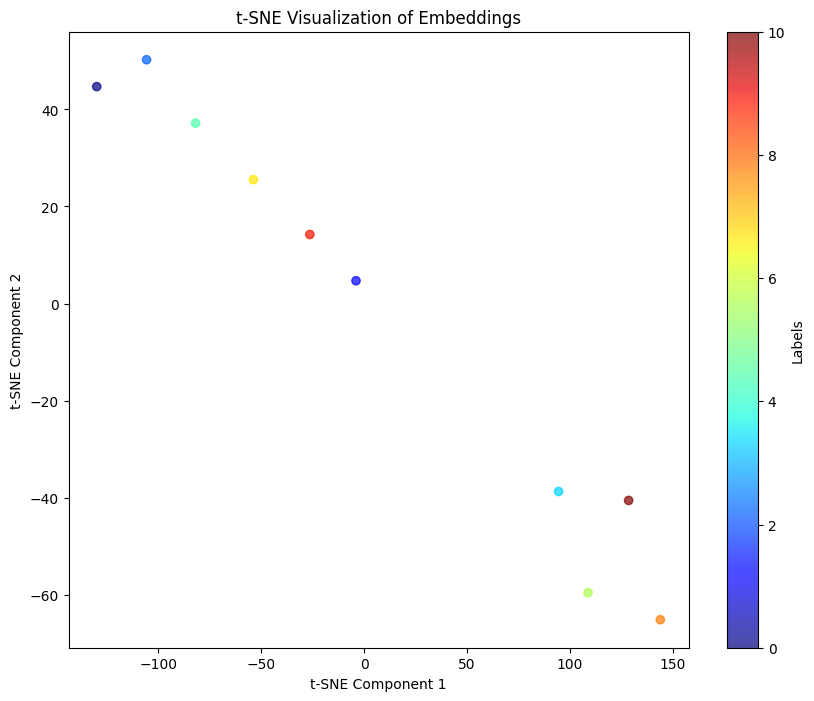

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


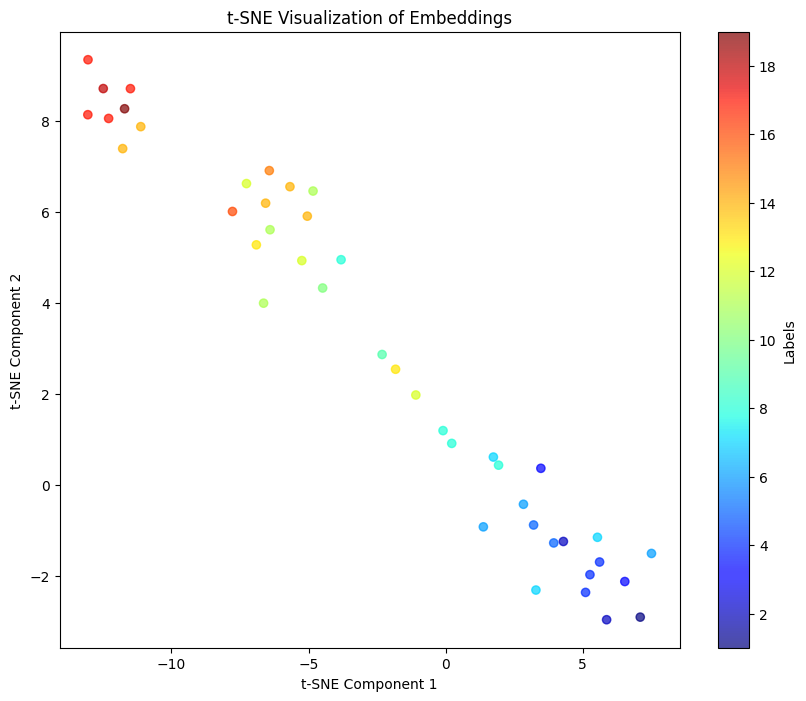

/home/mrunmay/scratch/miniconda3/envs/gsam/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


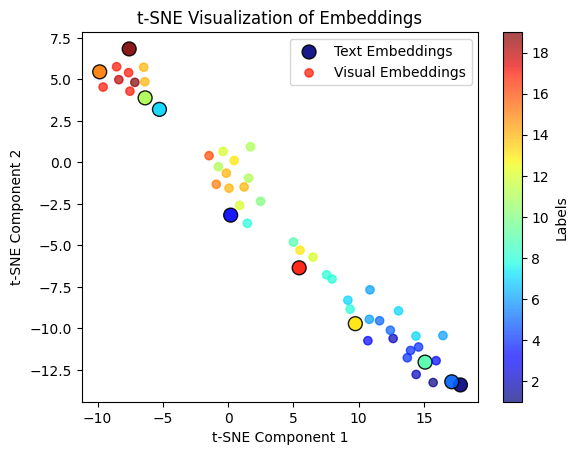

In [21]:
feats_list, score_list, text_feats, text_scores = get_feats_order_score('NETS', depth=4)
feats_list = F.normalize(feats_list, p=2, dim=-1)
text_feats = F.normalize(text_feats, p=2, dim=-1)
combined_feats = torch.concat([text_feats[0].detach().cpu(), feats_list.detach().cpu()], dim=0)
combined_scores = torch.concat([text_scores[0].detach().cpu(), score_list.detach().cpu()], dim=0)
visualize_embeddings_normal(text_feats[0], text_scores[0], perplexity=3)
visualize_embeddings_normal(feats_list, score_list, perplexity=10)
visualize_embeddings(combined_feats, combined_scores, perplexity=10)

Some weights of FeatureExtractor were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized: ['videomae.peft_embeddings.meta_net.linear1.weight', 'videomae.peft_embeddings.meta_net.linear2.weight', 'videomae.peft_embeddings.trainable_vectors', 'videomae.projection_head.fc.bias', 'videomae.projection_head.fc.weight', 'videomae.projection_head.layer_norm.bias', 'videomae.projection_head.layer_norm.weight', 'videomae.projection_head.projection.bias', 'videomae.projection_head.projection.weight', 'videomae.weigher.cross_attention.k.bias', 'videomae.weigher.cross_attention.k.weight', 'videomae.weigher.cross_attention.ln1.bias', 'videomae.weigher.cross_attention.ln1.weight', 'videomae.weigher.cross_attention.proj.bias', 'videomae.weigher.cross_attention.proj.weight', 'videomae.weigher.cross_attention.q.bias', 'videomae.weigher.cross_attention.q.weight', 'videomae.weigher.cross_attention.v.bias', 'videomae.weigher.cross_attention.v.wei

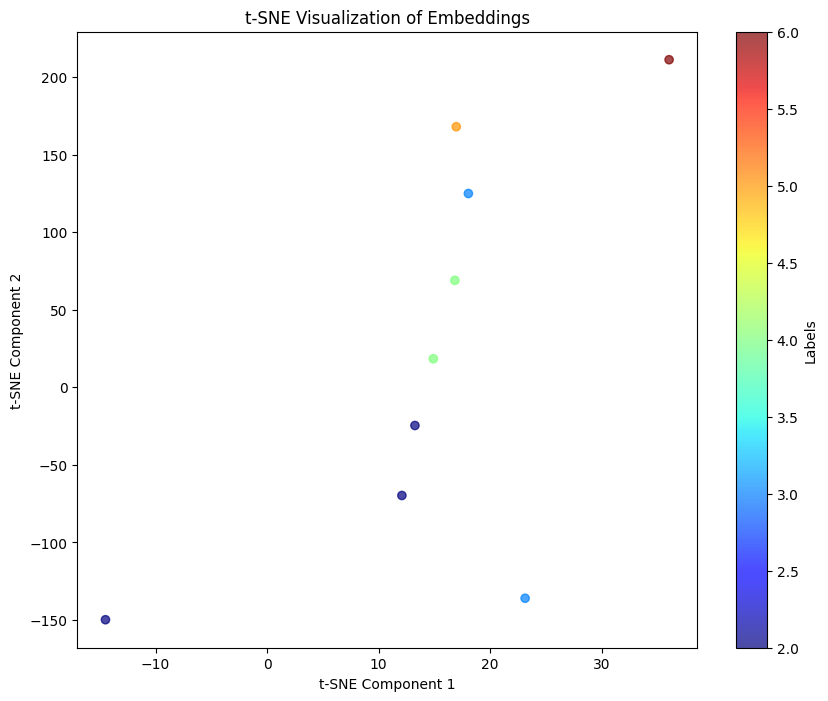

Some weights of FeatureExtractor were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized: ['videomae.peft_embeddings.meta_net.linear1.weight', 'videomae.peft_embeddings.meta_net.linear2.weight', 'videomae.peft_embeddings.trainable_vectors', 'videomae.projection_head.fc.bias', 'videomae.projection_head.fc.weight', 'videomae.projection_head.layer_norm.bias', 'videomae.projection_head.layer_norm.weight', 'videomae.projection_head.projection.bias', 'videomae.projection_head.projection.weight', 'videomae.weigher.cross_attention.k.bias', 'videomae.weigher.cross_attention.k.weight', 'videomae.weigher.cross_attention.ln1.bias', 'videomae.weigher.cross_attention.ln1.weight', 'videomae.weigher.cross_attention.proj.bias', 'videomae.weigher.cross_attention.proj.weight', 'videomae.weigher.cross_attention.q.bias', 'videomae.weigher.cross_attention.q.weight', 'videomae.weigher.cross_attention.v.bias', 'videomae.weigher.cross_attention.v.wei

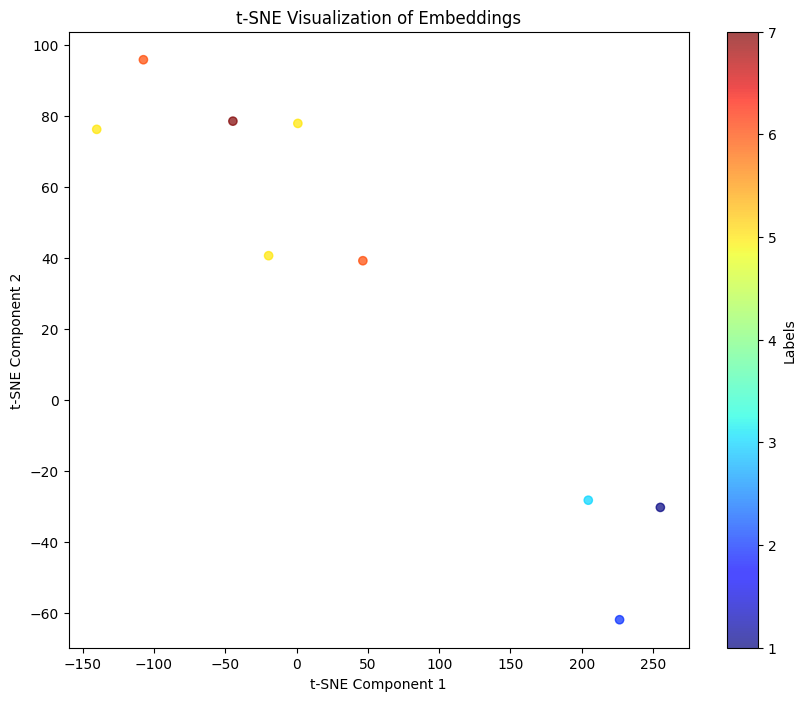

Some weights of FeatureExtractor were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized: ['videomae.peft_embeddings.meta_net.linear1.weight', 'videomae.peft_embeddings.meta_net.linear2.weight', 'videomae.peft_embeddings.trainable_vectors', 'videomae.projection_head.fc.bias', 'videomae.projection_head.fc.weight', 'videomae.projection_head.layer_norm.bias', 'videomae.projection_head.layer_norm.weight', 'videomae.projection_head.projection.bias', 'videomae.projection_head.projection.weight', 'videomae.weigher.cross_attention.k.bias', 'videomae.weigher.cross_attention.k.weight', 'videomae.weigher.cross_attention.ln1.bias', 'videomae.weigher.cross_attention.ln1.weight', 'videomae.weigher.cross_attention.proj.bias', 'videomae.weigher.cross_attention.proj.weight', 'videomae.weigher.cross_attention.q.bias', 'videomae.weigher.cross_attention.q.weight', 'videomae.weigher.cross_attention.v.bias', 'videomae.weigher.cross_attention.v.wei

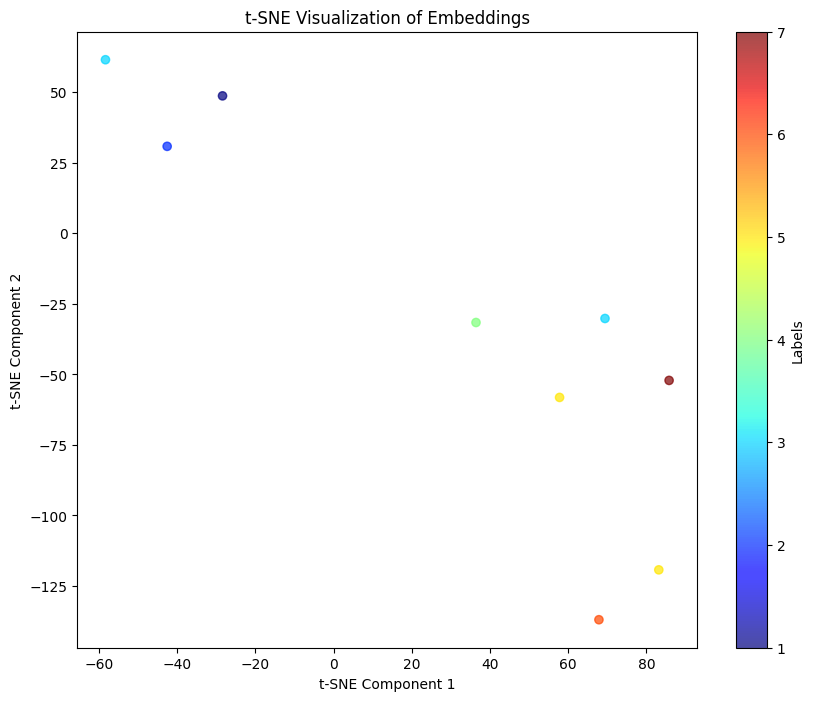

Some weights of FeatureExtractor were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized: ['videomae.peft_embeddings.meta_net.linear1.weight', 'videomae.peft_embeddings.meta_net.linear2.weight', 'videomae.peft_embeddings.trainable_vectors', 'videomae.projection_head.fc.bias', 'videomae.projection_head.fc.weight', 'videomae.projection_head.layer_norm.bias', 'videomae.projection_head.layer_norm.weight', 'videomae.projection_head.projection.bias', 'videomae.projection_head.projection.weight', 'videomae.weigher.cross_attention.k.bias', 'videomae.weigher.cross_attention.k.weight', 'videomae.weigher.cross_attention.ln1.bias', 'videomae.weigher.cross_attention.ln1.weight', 'videomae.weigher.cross_attention.proj.bias', 'videomae.weigher.cross_attention.proj.weight', 'videomae.weigher.cross_attention.q.bias', 'videomae.weigher.cross_attention.q.weight', 'videomae.weigher.cross_attention.v.bias', 'videomae.weigher.cross_attention.v.wei

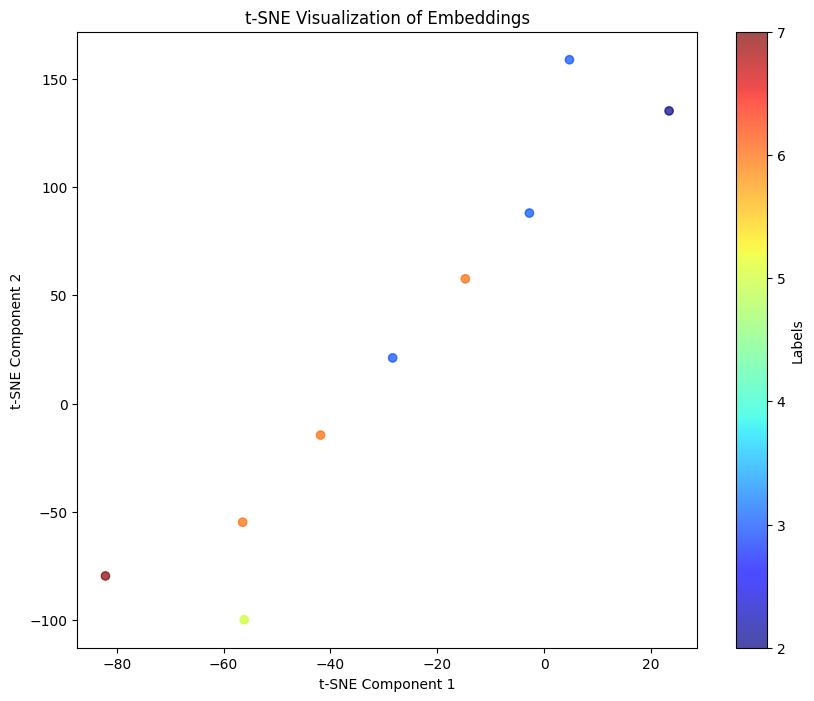

In [67]:
# Knot tying fold 0
feats_list, gol_feats_list, score_list, order_list, reference_points = get_feats_order_score('Knot_Tying', fold=0, depth=4)
visualize_embeddings(gol_feats_list, order_list, perplexity=3)

# Knot tying fold 1
feats_list, gol_feats_list, score_list, order_list, reference_points = get_feats_order_score('Knot_Tying', fold=1)
visualize_embeddings(gol_feats_list, order_list, perplexity=3)

# Knot tying fold 2
feats_list, gol_feats_list, score_list, order_list, reference_points = get_feats_order_score('Knot_Tying', fold=2)
visualize_embeddings(gol_feats_list, order_list, perplexity=3)

# Knot tying fold 3
feats_list, gol_feats_list, score_list, order_list, reference_points = get_feats_order_score('Knot_Tying', fold=3)
visualize_embeddings(gol_feats_list, order_list, perplexity=3)

In [2]:
# Knot tying fold 0
feats_list, gol_feats_list, score_list, order_list, reference_points = get_feats_order_score('Suturing', fold=0)
visualize_embeddings(gol_feats_list, order_list, perplexity=3)

# Knot tying fold 1
feats_list, gol_feats_list, score_list, order_list, reference_points = get_feats_order_score('Suturing', fold=1)
visualize_embeddings(gol_feats_list, order_list, perplexity=3)

# Knot tying fold 2
feats_list, gol_feats_list, score_list, order_list, reference_points = get_feats_order_score('Suturing', fold=2)
visualize_embeddings(gol_feats_list, order_list, perplexity=3)

# Knot tying fold 3
feats_list, gol_feats_list, score_list, order_list, reference_points = get_feats_order_score('Suturing', fold=3)
visualize_embeddings(gol_feats_list, order_list, perplexity=3)

NameError: name 'get_feats_order_score' is not defined

Some weights of FeatureExtractor were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized: ['videomae.peft_embeddings.meta_net.linear1.weight', 'videomae.peft_embeddings.meta_net.linear2.weight', 'videomae.peft_embeddings.trainable_vectors', 'videomae.projection_head.fc.bias', 'videomae.projection_head.fc.weight', 'videomae.projection_head.layer_norm.bias', 'videomae.projection_head.layer_norm.weight', 'videomae.projection_head.projection.bias', 'videomae.projection_head.projection.weight', 'videomae.weigher.cross_attention.k.bias', 'videomae.weigher.cross_attention.k.weight', 'videomae.weigher.cross_attention.ln1.bias', 'videomae.weigher.cross_attention.ln1.weight', 'videomae.weigher.cross_attention.proj.bias', 'videomae.weigher.cross_attention.proj.weight', 'videomae.weigher.cross_attention.q.bias', 'videomae.weigher.cross_attention.q.weight', 'videomae.weigher.cross_attention.v.bias', 'videomae.weigher.cross_attention.v.wei

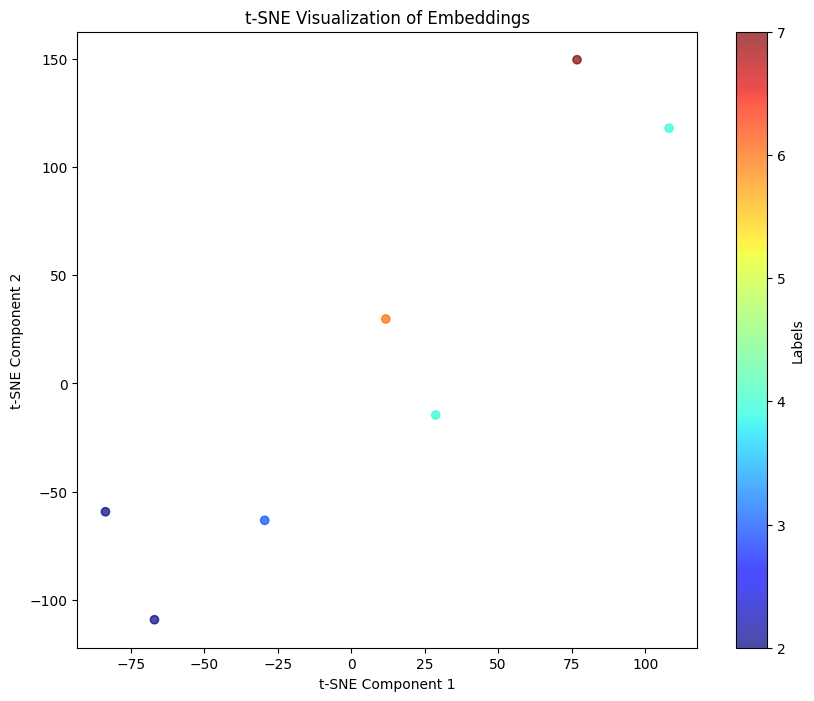

Some weights of FeatureExtractor were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized: ['videomae.peft_embeddings.meta_net.linear1.weight', 'videomae.peft_embeddings.meta_net.linear2.weight', 'videomae.peft_embeddings.trainable_vectors', 'videomae.projection_head.fc.bias', 'videomae.projection_head.fc.weight', 'videomae.projection_head.layer_norm.bias', 'videomae.projection_head.layer_norm.weight', 'videomae.projection_head.projection.bias', 'videomae.projection_head.projection.weight', 'videomae.weigher.cross_attention.k.bias', 'videomae.weigher.cross_attention.k.weight', 'videomae.weigher.cross_attention.ln1.bias', 'videomae.weigher.cross_attention.ln1.weight', 'videomae.weigher.cross_attention.proj.bias', 'videomae.weigher.cross_attention.proj.weight', 'videomae.weigher.cross_attention.q.bias', 'videomae.weigher.cross_attention.q.weight', 'videomae.weigher.cross_attention.v.bias', 'videomae.weigher.cross_attention.v.wei

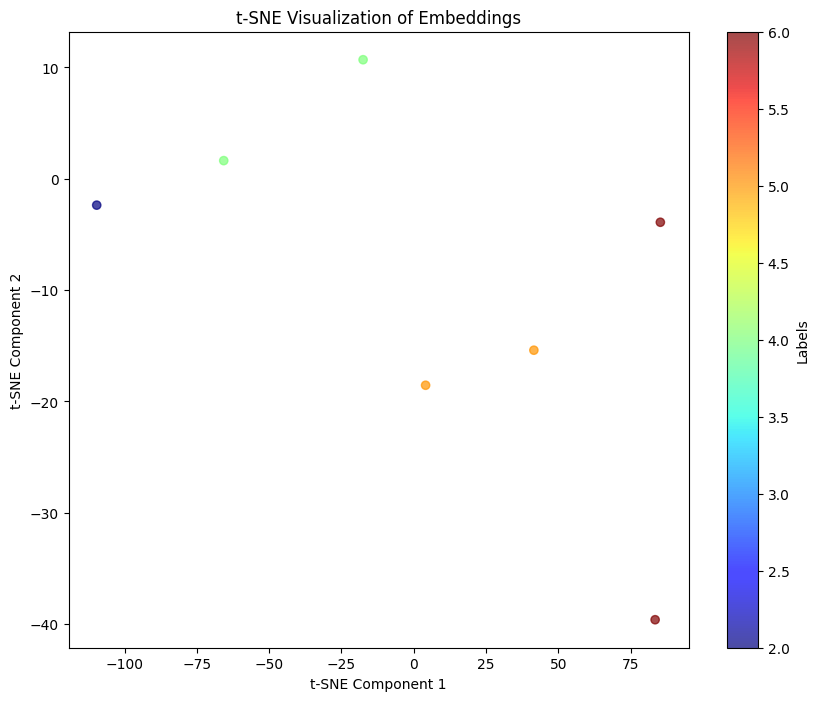

Some weights of FeatureExtractor were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized: ['videomae.peft_embeddings.meta_net.linear1.weight', 'videomae.peft_embeddings.meta_net.linear2.weight', 'videomae.peft_embeddings.trainable_vectors', 'videomae.projection_head.fc.bias', 'videomae.projection_head.fc.weight', 'videomae.projection_head.layer_norm.bias', 'videomae.projection_head.layer_norm.weight', 'videomae.projection_head.projection.bias', 'videomae.projection_head.projection.weight', 'videomae.weigher.cross_attention.k.bias', 'videomae.weigher.cross_attention.k.weight', 'videomae.weigher.cross_attention.ln1.bias', 'videomae.weigher.cross_attention.ln1.weight', 'videomae.weigher.cross_attention.proj.bias', 'videomae.weigher.cross_attention.proj.weight', 'videomae.weigher.cross_attention.q.bias', 'videomae.weigher.cross_attention.q.weight', 'videomae.weigher.cross_attention.v.bias', 'videomae.weigher.cross_attention.v.wei

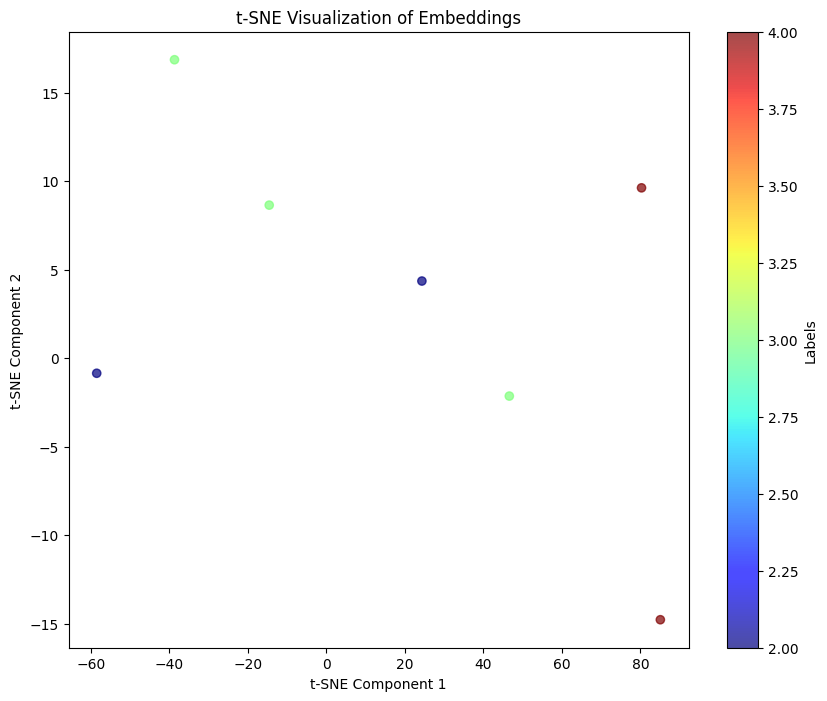

Some weights of FeatureExtractor were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized: ['videomae.peft_embeddings.meta_net.linear1.weight', 'videomae.peft_embeddings.meta_net.linear2.weight', 'videomae.peft_embeddings.trainable_vectors', 'videomae.projection_head.fc.bias', 'videomae.projection_head.fc.weight', 'videomae.projection_head.layer_norm.bias', 'videomae.projection_head.layer_norm.weight', 'videomae.projection_head.projection.bias', 'videomae.projection_head.projection.weight', 'videomae.weigher.cross_attention.k.bias', 'videomae.weigher.cross_attention.k.weight', 'videomae.weigher.cross_attention.ln1.bias', 'videomae.weigher.cross_attention.ln1.weight', 'videomae.weigher.cross_attention.proj.bias', 'videomae.weigher.cross_attention.proj.weight', 'videomae.weigher.cross_attention.q.bias', 'videomae.weigher.cross_attention.q.weight', 'videomae.weigher.cross_attention.v.bias', 'videomae.weigher.cross_attention.v.wei

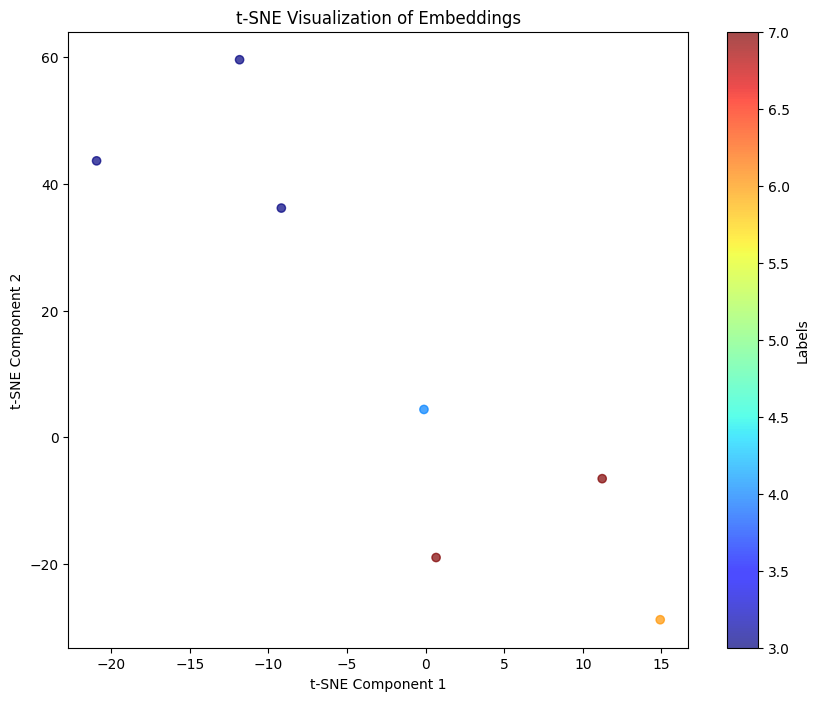

In [69]:
# Knot tying fold 0
feats_list, gol_feats_list, score_list, order_list, reference_points = get_feats_order_score('Needle_Passing', fold=0)
visualize_embeddings(gol_feats_list, order_list, perplexity=3)

# Knot tying fold 1
feats_list, gol_feats_list, score_list, order_list, reference_points = get_feats_order_score('Needle_Passing', fold=1)
visualize_embeddings(gol_feats_list, order_list, perplexity=3)

# Knot tying fold 2
feats_list, gol_feats_list, score_list, order_list, reference_points = get_feats_order_score('Needle_Passing', fold=2, depth=4)
visualize_embeddings(gol_feats_list, order_list, perplexity=3)

# Knot tying fold 3
feats_list, gol_feats_list, score_list, order_list, reference_points = get_feats_order_score('Needle_Passing', fold=3, depth=4)
visualize_embeddings(gol_feats_list, order_list, perplexity=3)

In [44]:
import torch
import torch.nn.functional as F

def decode_learned_prompt(prompt_embeddings, embedding_matrix, tokenizer):
    """
    Decodes learned prompt embeddings into the closest text tokens from CLIP vocabulary.

    Args:
        prompt_embeddings (torch.Tensor): (num_tokens, C_embed)
        embedding_matrix (torch.Tensor): (vocab_size, C_embed)
        tokenizer: CLIP tokenizer (must have `decode` method)

    Returns:
        str: Decoded text representing the learned tokens
    """
    # Normalize both to use cosine similarity
    # prompt_norm = F.normalize(prompt_embeddings, dim=-1)
    # embedding_norm = F.normalize(embedding_matrix, dim=-1)
    prompt_norm = prompt_embeddings
    embedding_norm = embedding_matrix

    # (num_tokens, vocab_size): similarity between each prompt token and vocab embeddings
    similarity = torch.matmul(prompt_norm, embedding_norm.T)

    # Find closest token index for each prompt token
    token_ids = similarity.argmax(dim=-1).tolist()

    # Decode token ids into string
    decoded_string = tokenizer.decode(token_ids)

    return decoded_string, similarity

In [45]:
args = get_args(dataset='NETS', fold=0, depth=5, num_ranks=10)

# Models
feature_extractor, language_prototypes, optimizer, criterion, text_processor = get_models(args)

coop_model = language_prototypes.learnable_tokens(torch.randn((10, 512)))
embedding_matrix = language_prototypes.text_encoder.text_model.embeddings.token_embedding.weight

In [46]:
sent, sim = decode_learned_prompt(coop_model, embedding_matrix, text_processor)
sent

'⏰ <- oak fineart yates bbo streams jess avg dangerously obscure save worried algoncrafgabriel'

In [47]:
sim.max(-1)

torch.return_types.max(
values=tensor([1.4877, 1.2577, 1.4240, 1.2948, 1.0493, 1.3324, 1.5346, 1.2206, 1.1056,
        1.1549, 1.0555, 1.3038, 1.3037, 1.1321, 1.3016, 1.2307],
       device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([12714, 47280,  7221, 16005, 27677, 21892, 13545, 13758, 19452, 35012,
        33337,  2673, 11911, 33007, 10873, 13244], device='cuda:0'))